In [1]:
# Import necessary libraries
from __future__ import division, print_function, unicode_literals

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import tensorflow as tf
import numpy as np
from functools import partial
import glob, os
import pickle
import copy

In [2]:
# User inputs
data_train_len = 20  # Number of training data files
data_name = 'Burgers_Eqn_exp28'  # Prefix of data files
folder_name = 'Burgers_exp28b/'  # Folder to be created for saved output

In [3]:
# Find the model with lowest validation error
import math

def BestErrorFile(folder_name):

    filename_best = ''
    best_error = 10**6

    current_dir = os.getcwd()
    os.chdir("./" + folder_name)
    for file in glob.glob("*.pkl"):
        with open(file, 'rb') as f:
            params = pickle.load(f)
            if not math.isnan(params['minRegTest']):
                if params['minRegTest'] < best_error:
                    filename_best = file
                    best_error = params['minRegTest']
    os.chdir(current_dir)

    return filename_best

pkl_file = folder_name + BestErrorFile(folder_name)

with open(pkl_file, 'rb') as f:
     params = pickle.load(f)

params['model_restore_path'] = params['model_path']
print(pkl_file)
print(params['minTest'])
print(params['minTrain'])

Burgers_exp28b/Burgers_Eqn_exp28_2019_06_08_15_25_06_752125_model.pkl
0.024240266531705856
0.016989925876259804


In [4]:
# Create numpy arrays with data

# Use these lines to load all data
data_train = np.load(('./data/%s_train1_x.npy' % (data_name)))
data_val = np.load(('./data/%s_val_x.npy' % data_name))
#data_test = np.load(('./data/%s_test_x.npy' % data_name))


In [5]:
import helperfns_convnet

max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
data_val_tensor = helperfns_convnet.stack_data(data_val, max_shifts_to_stack, params['val_len_time'])
data_train_tensor = helperfns_convnet.stack_data(data_train, max_shifts_to_stack, params['train_len_time'][0])
#data_test_tensor = helperfns_convnet.stack_data(data_test, max_shifts_to_stack, params['val_len_time'])

In [37]:
# Run a session to get encoded (initial condition), prediction (final time), loss
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    
    train_encoded, train_outputs, train_loss = sess.run(["encoder/v_k/Exp:0","decoder_outer_151/outputs/BiasAdd:0","loss:0"], feed_dict={"x:0": data_train_tensor})   
    val_encoded, val_outputs, val_loss = sess.run(["encoder/v_k/Exp:0","decoder_outer_151/outputs/BiasAdd:0","loss:0"], feed_dict={"x:0": data_val_tensor}) 
    test_encoded, test_outputs, test_loss = sess.run(["encoder/v_k/Exp:0","decoder_outer_151/outputs/BiasAdd:0","loss:0"], feed_dict={"x:0": data_test_tensor}) 
    
    
    #train_encoded, train_outputs, train_loss = sess.run(["encoder/v_k/Exp:0","decoder_outer_5/outputs/BiasAdd:0","loss:0"], feed_dict={"x:0": data_train_tensor})   
    #val_encoded, val_outputs, val_loss = sess.run(["encoder/v_k/Exp:0","decoder_outer_5/outputs/BiasAdd:0","loss:0"], feed_dict={"x:0": data_val_tensor}) 
    #test_encoded, test_outputs, test_loss = sess.run(["encoder/v_k/Exp:0","decoder_outer_5/outputs/BiasAdd:0","loss:0"], feed_dict={"x:0": data_test_tensor}) 
    
    #mu_pred = sess.run(tf.get_default_graph().get_tensor_by_name("dynamics/mu:0"))
    print(train_loss)
    print(val_loss)
    print(test_loss)
    #print(mu_pred)
     
    

INFO:tensorflow:Restoring parameters from ./Burgers_exp21l/Burgers_Eqn_exp21_2019_03_19_22_15_50_742074_model.ckpt
[0.00706893]
[0.00677489]
[0.01225518]


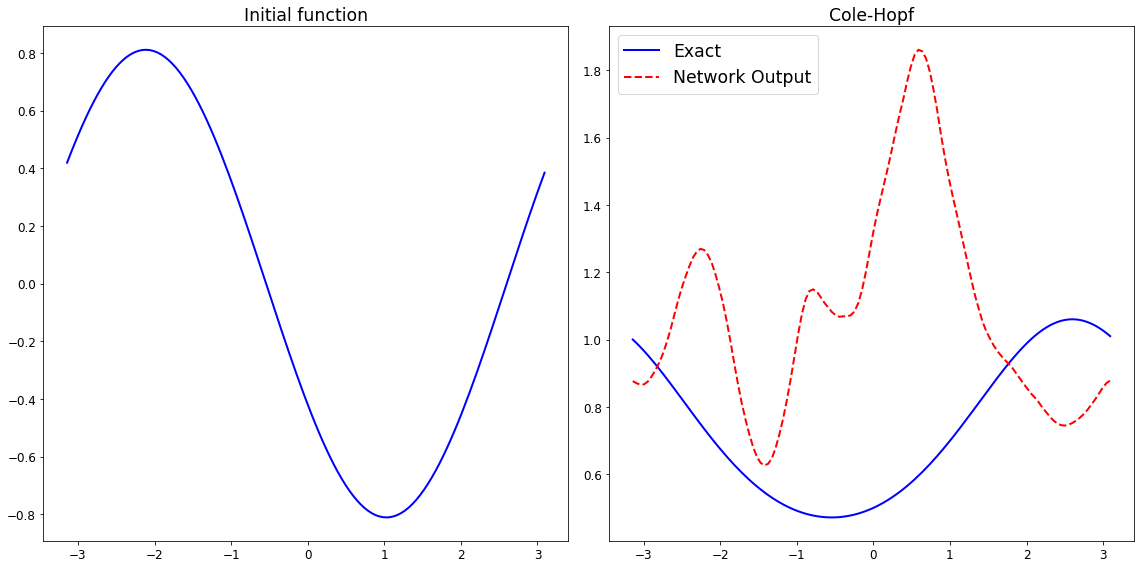

In [16]:
# Plot Cole-Hopf
from scipy.integrate import cumtrapz

# Inputs
eps = 1
mu = 1
data = 'val'  # 'train', 'val', or 'test'
ind = 10000    # index of initial condition

if data == 'train':
    encoded = train_encoded
    data_tensor = data_train_tensor
elif data == 'val':
    encoded = val_encoded
    data_tensor = data_val_tensor
else:
    encoded = test_encoded
    data_tensor = data_test_tensor

x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]  
    
f = data_tensor[0,ind,:]
int_vec = cumtrapz(f, x_pts, initial=0)
v = np.exp(-eps*int_vec/(2*mu))


f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.plot(x_pts, data_tensor[0,ind,:], "b-", linewidth=2)
ax1.set_title('Initial function', fontsize='xx-large')
ax2.plot(x_pts, v, "b-", linewidth=2)
ax2.plot(x_pts, encoded[ind,:], "r--", linewidth=2)
ax2.set_title('Cole-Hopf', fontsize='xx-large')
ax2.legend(['Exact','Network Output'], loc=2, fontsize='xx-large')
    
plt.tight_layout()
plt.show()
#plt.savefig('Exp21f_Encoded')
    
    

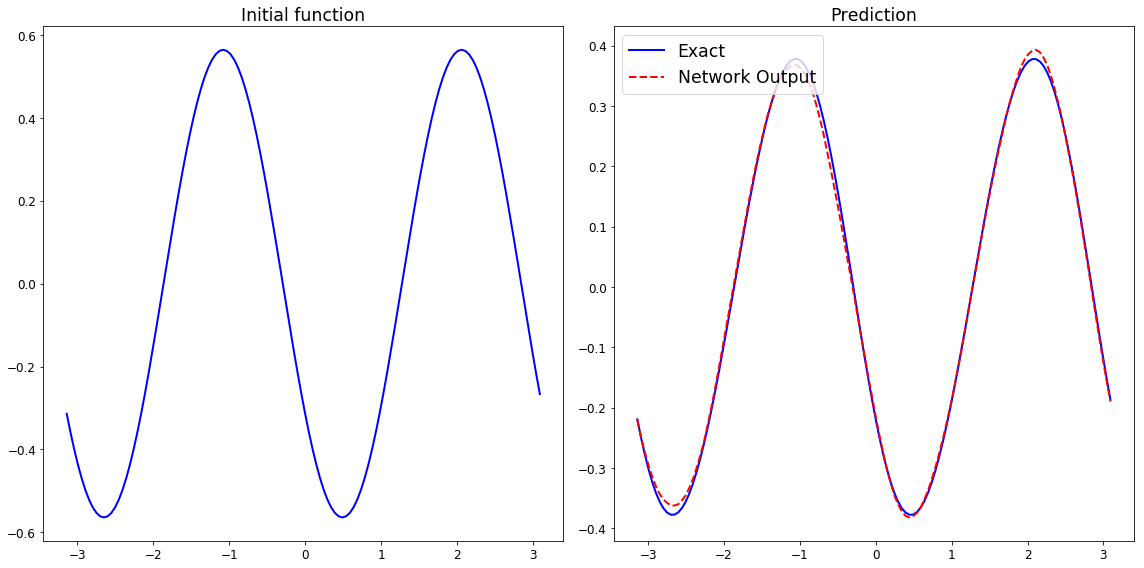

In [88]:
# Plot prediction 

# Inputs
eps = 1
mu = 1
data = 'test'  # 'train', 'val', or 'test'
ind = 1    # index of initial condition

if data == 'train':
    outputs = train_outputs
    data_tensor = data_train_tensor
elif data == 'val':
    outputs = val_outputs
    data_tensor = data_val_tensor
else:
    outputs = test_outputs
    data_tensor = data_test_tensor


x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
    
f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.plot(x_pts, data_tensor[0,ind,:], "b-", linewidth=2)
ax1.set_title('Initial function', fontsize='xx-large')
ax2.plot(x_pts, data_tensor[50,ind,:], "b-", linewidth=2)
ax2.plot(x_pts, outputs[ind,:], "r--", linewidth=2)
ax2.set_title('Prediction', fontsize='xx-large')
ax2.legend(['Exact','Network Output'], loc=2, fontsize='xx-large')
    
plt.tight_layout()
plt.show()
#plt.savefig('Exp21f_Pred')

In [125]:
# List all graph operations (if necessary to do more post processing)
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
     
    graph = tf.get_default_graph()
    for op in graph.get_operations():
        print(op.name)
        
    
    

INFO:tensorflow:Restoring parameters from ./Burgers_exp21b/Burgers_Eqn_exp21_2019_02_19_05_45_14_528438_model.ckpt
phase
keep_prob
Placeholder
Placeholder_1
random_uniform/shape
random_uniform/min
random_uniform/max
random_uniform/RandomUniform
random_uniform/sub
random_uniform/mul
random_uniform
WE1
WE1/Assign
WE1/read
Const
bE1
bE1/Assign
bE1/read
random_uniform_1/shape
random_uniform_1/min
random_uniform_1/max
random_uniform_1/RandomUniform
random_uniform_1/sub
random_uniform_1/mul
random_uniform_1
WE2
WE2/Assign
WE2/read
Const_1
bE2
bE2/Assign
bE2/read
random_uniform_2/shape
random_uniform_2/min
random_uniform_2/max
random_uniform_2/RandomUniform
random_uniform_2/sub
random_uniform_2/mul
random_uniform_2
WE3
WE3/Assign
WE3/read
Const_2
bE3
bE3/Assign
bE3/read
random_uniform_3/shape
random_uniform_3/min
random_uniform_3/max
random_uniform_3/RandomUniform
random_uniform_3/sub
random_uniform_3/mul
random_uniform_3
WE4
WE4/Assign
WE4/read
Const_3
bE4
bE4/Assign
bE4/read
random_uniform_

MatMul_406
add_473
Relu_271
MatMul_407
add_474
scalar_67
mul_67
add_475
Identity_85
MatMul_408
add_476
Identity_86
MatMul_409
add_477
Relu_272
MatMul_410
add_478
Relu_273
MatMul_411
add_479
Relu_274
MatMul_412
add_480
Relu_275
MatMul_413
add_481
scalar_68
mul_68
add_482
Identity_87
MatMul_414
add_483
Identity_88
MatMul_415
add_484
Relu_276
MatMul_416
add_485
Relu_277
MatMul_417
add_486
Relu_278
MatMul_418
add_487
Relu_279
MatMul_419
add_488
scalar_69
mul_69
add_489
Identity_89
MatMul_420
add_490
Identity_90
MatMul_421
add_491
Relu_280
MatMul_422
add_492
Relu_281
MatMul_423
add_493
Relu_282
MatMul_424
add_494
Relu_283
MatMul_425
add_495
scalar_70
mul_70
add_496
Identity_91
MatMul_426
add_497
Identity_92
MatMul_427
add_498
Relu_284
MatMul_428
add_499
Relu_285
MatMul_429
add_500
Relu_286
MatMul_430
add_501
Relu_287
MatMul_431
add_502
scalar_71
mul_71
add_503
Identity_93
MatMul_432
add_504
Identity_94
MatMul_433
add_505
Relu_288
MatMul_434
add_506
Relu_289
MatMul_435
add_507
Relu_290
MatMu

add_1001
scalar_149
mul_149
add_1002
Identity_202
MatMul_853
add_1003
Relu_600
MatMul_854
add_1004
Relu_601
MatMul_855
add_1005
Relu_602
MatMul_856
add_1006
Relu_603
MatMul_857
add_1007
scalar_150
mul_150
add_1008
Identity_203
MatMul_858
add_1009
Relu_604
MatMul_859
add_1010
Relu_605
MatMul_860
add_1011
Relu_606
MatMul_861
add_1012
Relu_607
MatMul_862
add_1013
scalar_151
mul_151
add_1014
Identity_204
MatMul_863
add_1015
Relu_608
MatMul_864
add_1016
Relu_609
MatMul_865
add_1017
Relu_610
MatMul_866
add_1018
Relu_611
MatMul_867
add_1019
scalar_152
mul_152
add_1020
Identity_205
MatMul_868
add_1021
Relu_612
MatMul_869
add_1022
Relu_613
MatMul_870
add_1023
Relu_614
MatMul_871
add_1024
Relu_615
MatMul_872
add_1025
scalar_153
mul_153
add_1026
MatMul_873
Identity_206
MatMul_874
add_1027
Identity_207
MatMul_875
add_1028
MatMul_876
add_1029
MatMul_877
add_1030
MatMul_878
add_1031
MatMul_879
add_1032
scalar_154
mul_154
add_1033
MatMul_880
Identity_208
MatMul_881
add_1034
Identity_209
MatMul_882
ad

range_40/delta
range_40
Mean_81
add_1417/y
add_1417
strided_slice_92/stack
strided_slice_92/stack_1
strided_slice_92/stack_2
strided_slice_92
Squeeze_92
sub_20
Square_41
Mean_82/reduction_indices
Mean_82
Rank_41
range_41/start
range_41/delta
range_41
Mean_83
truediv_20
mul_224/x
mul_224
add_1418
strided_slice_93/stack
strided_slice_93/stack_1
strided_slice_93/stack_2
strided_slice_93
Squeeze_93
Square_42
Mean_84/reduction_indices
Mean_84
Rank_42
range_42/start
range_42/delta
range_42
Mean_85
add_1419/y
add_1419
strided_slice_94/stack
strided_slice_94/stack_1
strided_slice_94/stack_2
strided_slice_94
Squeeze_94
sub_21
Square_43
Mean_86/reduction_indices
Mean_86
Rank_43
range_43/start
range_43/delta
range_43
Mean_87
truediv_21
mul_225/x
mul_225
add_1420
strided_slice_95/stack
strided_slice_95/stack_1
strided_slice_95/stack_2
strided_slice_95
Squeeze_95
Square_44
Mean_88/reduction_indices
Mean_88
Rank_44
range_44/start
range_44/delta
range_44
Mean_89
add_1421/y
add_1421
strided_slice_96/s

range_142
Mean_285
add_1519/y
add_1519
strided_slice_194/stack
strided_slice_194/stack_1
strided_slice_194/stack_2
strided_slice_194
Squeeze_194
sub_71
Square_143
Mean_286/reduction_indices
Mean_286
Rank_143
range_143/start
range_143/delta
range_143
Mean_287
truediv_71
mul_275/x
mul_275
add_1520
strided_slice_195/stack
strided_slice_195/stack_1
strided_slice_195/stack_2
strided_slice_195
Squeeze_195
Square_144
Mean_288/reduction_indices
Mean_288
Rank_144
range_144/start
range_144/delta
range_144
Mean_289
add_1521/y
add_1521
strided_slice_196/stack
strided_slice_196/stack_1
strided_slice_196/stack_2
strided_slice_196
Squeeze_196
sub_72
Square_145
Mean_290/reduction_indices
Mean_290
Rank_145
range_145/start
range_145/delta
range_145
Mean_291
truediv_72
mul_276/x
mul_276
add_1522
strided_slice_197/stack
strided_slice_197/stack_1
strided_slice_197/stack_2
strided_slice_197
Squeeze_197
Square_146
Mean_292/reduction_indices
Mean_292
Rank_146
range_146/start
range_146/delta
range_146
Mean_293

truediv_132
mul_336/x
mul_336
add_1642
MatMul_1256
Squeeze_285
Square_266
Mean_532/reduction_indices
Mean_532
Rank_234
range_234/start
range_234/delta
range_234
Mean_533
add_1643/y
add_1643
sub_133
Square_267
Mean_534/reduction_indices
Mean_534
Const_42
Mean_535
truediv_133
mul_337/x
mul_337
add_1644
MatMul_1257
Squeeze_286
Square_268
Mean_536/reduction_indices
Mean_536
Rank_235
range_235/start
range_235/delta
range_235
Mean_537
add_1645/y
add_1645
sub_134
Square_269
Mean_538/reduction_indices
Mean_538
Const_43
Mean_539
truediv_134
mul_338/x
mul_338
add_1646
MatMul_1258
Squeeze_287
Square_270
Mean_540/reduction_indices
Mean_540
Rank_236
range_236/start
range_236/delta
range_236
Mean_541
add_1647/y
add_1647
sub_135
Square_271
Mean_542/reduction_indices
Mean_542
Const_44
Mean_543
truediv_135
mul_339/x
mul_339
add_1648
MatMul_1259
Squeeze_288
Square_272
Mean_544/reduction_indices
Mean_544
Rank_237
range_237/start
range_237/delta
range_237
Mean_545
add_1649/y
add_1649
sub_136
Square_273
Me

Mean_777
add_1851/y
add_1851
MatMul_1361
add_1852
MatMul_1362
add_1853
sub_194
Square_389
Mean_778/reduction_indices
Mean_778
Rank_339
range_339/start
range_339/delta
range_339
Mean_779
truediv_194
mul_398/x
mul_398
add_1854
Square_390
Mean_780/reduction_indices
Mean_780
Rank_340
range_340/start
range_340/delta
range_340
Mean_781
add_1855/y
add_1855
MatMul_1363
add_1856
MatMul_1364
add_1857
sub_195
Square_391
Mean_782/reduction_indices
Mean_782
Rank_341
range_341/start
range_341/delta
range_341
Mean_783
truediv_195
mul_399/x
mul_399
add_1858
Square_392
Mean_784/reduction_indices
Mean_784
Rank_342
range_342/start
range_342/delta
range_342
Mean_785
add_1859/y
add_1859
MatMul_1365
add_1860
MatMul_1366
add_1861
sub_196
Square_393
Mean_786/reduction_indices
Mean_786
Rank_343
range_343/start
range_343/delta
range_343
Mean_787
truediv_196
mul_400/x
mul_400
add_1862
Square_394
Mean_788/reduction_indices
Mean_788
Rank_344
range_344/start
range_344/delta
range_344
Mean_789
add_1863/y
add_1863
Ma

range_440/delta
range_440
Mean_981
add_1969/y
add_1969
strided_slice_340/stack
strided_slice_340/stack_1
strided_slice_340/stack_2
strided_slice_340
Squeeze_390
sub_245
Square_491
Mean_982/reduction_indices
Mean_982
Rank_441
range_441/start
range_441/delta
range_441
Mean_983
truediv_245
mul_449/x
mul_449
add_1970
strided_slice_341/stack
strided_slice_341/stack_1
strided_slice_341/stack_2
strided_slice_341
Squeeze_391
Square_492
Mean_984/reduction_indices
Mean_984
Rank_442
range_442/start
range_442/delta
range_442
Mean_985
add_1971/y
add_1971
strided_slice_342/stack
strided_slice_342/stack_1
strided_slice_342/stack_2
strided_slice_342
Squeeze_392
sub_246
Square_493
Mean_986/reduction_indices
Mean_986
Rank_443
range_443/start
range_443/delta
range_443
Mean_987
truediv_246
mul_450/x
mul_450
add_1972
strided_slice_343/stack
strided_slice_343/stack_1
strided_slice_343/stack_2
strided_slice_343
Squeeze_393
Square_494
Mean_988/reduction_indices
Mean_988
Rank_444
range_444/start
range_444/delt

gradients/truediv_148_grad/tuple/control_dependency_1
gradients/Mean_599_grad/Reshape/shape
gradients/Mean_599_grad/Reshape
gradients/Mean_599_grad/Shape
gradients/Mean_599_grad/Tile
gradients/Mean_599_grad/Shape_1
gradients/Mean_599_grad/Shape_2
gradients/Mean_599_grad/Const
gradients/Mean_599_grad/Prod
gradients/Mean_599_grad/Const_1
gradients/Mean_599_grad/Prod_1
gradients/Mean_599_grad/Maximum/y
gradients/Mean_599_grad/Maximum
gradients/Mean_599_grad/floordiv
gradients/Mean_599_grad/Cast
gradients/Mean_599_grad/truediv
gradients/add_1675_grad/Shape
gradients/add_1675_grad/Shape_1
gradients/add_1675_grad/BroadcastGradientArgs
gradients/add_1675_grad/Sum
gradients/add_1675_grad/Reshape
gradients/add_1675_grad/Sum_1
gradients/add_1675_grad/Reshape_1
gradients/add_1675_grad/tuple/group_deps
gradients/add_1675_grad/tuple/control_dependency
gradients/add_1675_grad/tuple/control_dependency_1
gradients/Mean_602_grad/Shape
gradients/Mean_602_grad/Size
gradients/Mean_602_grad/add
gradients/M

gradients/Mean_789_grad/Maximum
gradients/Mean_789_grad/floordiv
gradients/Mean_789_grad/Reshape
gradients/Mean_789_grad/Tile
gradients/Mean_789_grad/Shape_2
gradients/Mean_789_grad/Shape_3
gradients/Mean_789_grad/Const
gradients/Mean_789_grad/Prod
gradients/Mean_789_grad/Const_1
gradients/Mean_789_grad/Prod_1
gradients/Mean_789_grad/Maximum_1/y
gradients/Mean_789_grad/Maximum_1
gradients/Mean_789_grad/floordiv_1
gradients/Mean_789_grad/Cast
gradients/Mean_789_grad/truediv
gradients/Mean_798_grad/Shape
gradients/Mean_798_grad/Size
gradients/Mean_798_grad/add
gradients/Mean_798_grad/mod
gradients/Mean_798_grad/Shape_1
gradients/Mean_798_grad/range/start
gradients/Mean_798_grad/range/delta
gradients/Mean_798_grad/range
gradients/Mean_798_grad/Fill/value
gradients/Mean_798_grad/Fill
gradients/Mean_798_grad/DynamicStitch
gradients/Mean_798_grad/Maximum/y
gradients/Mean_798_grad/Maximum
gradients/Mean_798_grad/floordiv
gradients/Mean_798_grad/Reshape
gradients/Mean_798_grad/Tile
gradients/M

gradients/truediv_43_grad/RealDiv_1
gradients/truediv_43_grad/RealDiv_2
gradients/truediv_43_grad/mul
gradients/truediv_43_grad/Sum_1
gradients/truediv_43_grad/Reshape_1
gradients/truediv_43_grad/tuple/group_deps
gradients/truediv_43_grad/tuple/control_dependency
gradients/truediv_43_grad/tuple/control_dependency_1
gradients/Mean_179_grad/Shape
gradients/Mean_179_grad/Size
gradients/Mean_179_grad/add
gradients/Mean_179_grad/mod
gradients/Mean_179_grad/Shape_1
gradients/Mean_179_grad/range/start
gradients/Mean_179_grad/range/delta
gradients/Mean_179_grad/range
gradients/Mean_179_grad/Fill/value
gradients/Mean_179_grad/Fill
gradients/Mean_179_grad/DynamicStitch
gradients/Mean_179_grad/Maximum/y
gradients/Mean_179_grad/Maximum
gradients/Mean_179_grad/floordiv
gradients/Mean_179_grad/Reshape
gradients/Mean_179_grad/Tile
gradients/Mean_179_grad/Shape_2
gradients/Mean_179_grad/Shape_3
gradients/Mean_179_grad/Const
gradients/Mean_179_grad/Prod
gradients/Mean_179_grad/Const_1
gradients/Mean_17

gradients/Mean_580_grad/Shape
gradients/Mean_580_grad/Size
gradients/Mean_580_grad/add
gradients/Mean_580_grad/mod
gradients/Mean_580_grad/Shape_1
gradients/Mean_580_grad/range/start
gradients/Mean_580_grad/range/delta
gradients/Mean_580_grad/range
gradients/Mean_580_grad/Fill/value
gradients/Mean_580_grad/Fill
gradients/Mean_580_grad/DynamicStitch
gradients/Mean_580_grad/Maximum/y
gradients/Mean_580_grad/Maximum
gradients/Mean_580_grad/floordiv
gradients/Mean_580_grad/Reshape
gradients/Mean_580_grad/Tile
gradients/Mean_580_grad/Shape_2
gradients/Mean_580_grad/Shape_3
gradients/Mean_580_grad/Const
gradients/Mean_580_grad/Prod
gradients/Mean_580_grad/Const_1
gradients/Mean_580_grad/Prod_1
gradients/Mean_580_grad/Maximum_1/y
gradients/Mean_580_grad/Maximum_1
gradients/Mean_580_grad/floordiv_1
gradients/Mean_580_grad/Cast
gradients/Mean_580_grad/truediv
gradients/Square_292_grad/mul/x
gradients/Square_292_grad/mul
gradients/Square_292_grad/mul_1
gradients/Squeeze_299_grad/Shape
gradients/

gradients/add_1367_grad/BroadcastGradientArgs
gradients/add_1367_grad/Sum
gradients/add_1367_grad/Reshape
gradients/add_1367_grad/Sum_1
gradients/add_1367_grad/Reshape_1
gradients/add_1367_grad/tuple/group_deps
gradients/add_1367_grad/tuple/control_dependency
gradients/add_1367_grad/tuple/control_dependency_1
gradients/MatMul_1221_grad/MatMul
gradients/MatMul_1221_grad/MatMul_1
gradients/MatMul_1221_grad/tuple/group_deps
gradients/MatMul_1221_grad/tuple/control_dependency
gradients/MatMul_1221_grad/tuple/control_dependency_1
gradients/add_1650_grad/Shape
gradients/add_1650_grad/Shape_1
gradients/add_1650_grad/BroadcastGradientArgs
gradients/add_1650_grad/Sum
gradients/add_1650_grad/Reshape
gradients/add_1650_grad/Sum_1
gradients/add_1650_grad/Reshape_1
gradients/add_1650_grad/tuple/group_deps
gradients/add_1650_grad/tuple/control_dependency
gradients/add_1650_grad/tuple/control_dependency_1
gradients/mul_341_grad/Shape
gradients/mul_341_grad/Shape_1
gradients/mul_341_grad/BroadcastGrad

gradients/truediv_87_grad/tuple/control_dependency
gradients/truediv_87_grad/tuple/control_dependency_1
gradients/Mean_355_grad/Shape
gradients/Mean_355_grad/Size
gradients/Mean_355_grad/add
gradients/Mean_355_grad/mod
gradients/Mean_355_grad/Shape_1
gradients/Mean_355_grad/range/start
gradients/Mean_355_grad/range/delta
gradients/Mean_355_grad/range
gradients/Mean_355_grad/Fill/value
gradients/Mean_355_grad/Fill
gradients/Mean_355_grad/DynamicStitch
gradients/Mean_355_grad/Maximum/y
gradients/Mean_355_grad/Maximum
gradients/Mean_355_grad/floordiv
gradients/Mean_355_grad/Reshape
gradients/Mean_355_grad/Tile
gradients/Mean_355_grad/Shape_2
gradients/Mean_355_grad/Shape_3
gradients/Mean_355_grad/Const
gradients/Mean_355_grad/Prod
gradients/Mean_355_grad/Const_1
gradients/Mean_355_grad/Prod_1
gradients/Mean_355_grad/Maximum_1/y
gradients/Mean_355_grad/Maximum_1
gradients/Mean_355_grad/floordiv_1
gradients/Mean_355_grad/Cast
gradients/Mean_355_grad/truediv
gradients/Mean_366_grad/Shape
gra

gradients/add_1544_grad/Sum_1
gradients/add_1544_grad/Reshape_1
gradients/add_1544_grad/tuple/group_deps
gradients/add_1544_grad/tuple/control_dependency
gradients/add_1544_grad/tuple/control_dependency_1
gradients/mul_288_grad/Shape
gradients/mul_288_grad/Shape_1
gradients/mul_288_grad/BroadcastGradientArgs
gradients/mul_288_grad/mul
gradients/mul_288_grad/Sum
gradients/mul_288_grad/Reshape
gradients/mul_288_grad/mul_1
gradients/mul_288_grad/Sum_1
gradients/mul_288_grad/Reshape_1
gradients/mul_288_grad/tuple/group_deps
gradients/mul_288_grad/tuple/control_dependency
gradients/mul_288_grad/tuple/control_dependency_1
gradients/truediv_85_grad/Shape
gradients/truediv_85_grad/Shape_1
gradients/truediv_85_grad/BroadcastGradientArgs
gradients/truediv_85_grad/RealDiv
gradients/truediv_85_grad/Sum
gradients/truediv_85_grad/Reshape
gradients/truediv_85_grad/Neg
gradients/truediv_85_grad/RealDiv_1
gradients/truediv_85_grad/RealDiv_2
gradients/truediv_85_grad/mul
gradients/truediv_85_grad/Sum_1


gradients/add_1325_grad/Sum
gradients/add_1325_grad/Reshape
gradients/add_1325_grad/Sum_1
gradients/add_1325_grad/Reshape_1
gradients/add_1325_grad/tuple/group_deps
gradients/add_1325_grad/tuple/control_dependency
gradients/add_1325_grad/tuple/control_dependency_1
gradients/MatMul_1179_grad/MatMul
gradients/MatMul_1179_grad/MatMul_1
gradients/MatMul_1179_grad/tuple/group_deps
gradients/MatMul_1179_grad/tuple/control_dependency
gradients/MatMul_1179_grad/tuple/control_dependency_1
gradients/add_1338_grad/Shape
gradients/add_1338_grad/Shape_1
gradients/add_1338_grad/BroadcastGradientArgs
gradients/add_1338_grad/Sum
gradients/add_1338_grad/Reshape
gradients/add_1338_grad/Sum_1
gradients/add_1338_grad/Reshape_1
gradients/add_1338_grad/tuple/group_deps
gradients/add_1338_grad/tuple/control_dependency
gradients/add_1338_grad/tuple/control_dependency_1
gradients/MatMul_1192_grad/MatMul
gradients/MatMul_1192_grad/MatMul_1
gradients/MatMul_1192_grad/tuple/group_deps
gradients/MatMul_1192_grad/t

gradients/add_947_grad/Reshape
gradients/add_947_grad/Sum_1
gradients/add_947_grad/Reshape_1
gradients/add_947_grad/tuple/group_deps
gradients/add_947_grad/tuple/control_dependency
gradients/add_947_grad/tuple/control_dependency_1
gradients/mul_140_grad/Shape
gradients/mul_140_grad/Shape_1
gradients/mul_140_grad/BroadcastGradientArgs
gradients/mul_140_grad/mul
gradients/mul_140_grad/Sum
gradients/mul_140_grad/Reshape
gradients/mul_140_grad/mul_1
gradients/mul_140_grad/Sum_1
gradients/mul_140_grad/Reshape_1
gradients/mul_140_grad/tuple/group_deps
gradients/mul_140_grad/tuple/control_dependency
gradients/mul_140_grad/tuple/control_dependency_1
gradients/MatMul_812_grad/MatMul
gradients/MatMul_812_grad/MatMul_1
gradients/MatMul_812_grad/tuple/group_deps
gradients/MatMul_812_grad/tuple/control_dependency
gradients/MatMul_812_grad/tuple/control_dependency_1
gradients/Relu_571_grad/ReluGrad
gradients/add_964_grad/Shape
gradients/add_964_grad/Shape_1
gradients/add_964_grad/BroadcastGradientAr

gradients/add_1637_grad/Reshape
gradients/add_1637_grad/Sum_1
gradients/add_1637_grad/Reshape_1
gradients/add_1637_grad/tuple/group_deps
gradients/add_1637_grad/tuple/control_dependency
gradients/add_1637_grad/tuple/control_dependency_1
gradients/Mean_526_grad/Shape
gradients/Mean_526_grad/Size
gradients/Mean_526_grad/add
gradients/Mean_526_grad/mod
gradients/Mean_526_grad/Shape_1
gradients/Mean_526_grad/range/start
gradients/Mean_526_grad/range/delta
gradients/Mean_526_grad/range
gradients/Mean_526_grad/Fill/value
gradients/Mean_526_grad/Fill
gradients/Mean_526_grad/DynamicStitch
gradients/Mean_526_grad/Maximum/y
gradients/Mean_526_grad/Maximum
gradients/Mean_526_grad/floordiv
gradients/Mean_526_grad/Reshape
gradients/Mean_526_grad/Tile
gradients/Mean_526_grad/Shape_2
gradients/Mean_526_grad/Shape_3
gradients/Mean_526_grad/Const
gradients/Mean_526_grad/Prod
gradients/Mean_526_grad/Const_1
gradients/Mean_526_grad/Prod_1
gradients/Mean_526_grad/Maximum_1/y
gradients/Mean_526_grad/Maximu

gradients/mul_88_grad/Reshape
gradients/mul_88_grad/mul_1
gradients/mul_88_grad/Sum_1
gradients/mul_88_grad/Reshape_1
gradients/mul_88_grad/tuple/group_deps
gradients/mul_88_grad/tuple/control_dependency
gradients/mul_88_grad/tuple/control_dependency_1
gradients/MatMul_539_grad/MatMul
gradients/MatMul_539_grad/MatMul_1
gradients/MatMul_539_grad/tuple/group_deps
gradients/MatMul_539_grad/tuple/control_dependency
gradients/MatMul_539_grad/tuple/control_dependency_1
gradients/Relu_363_grad/ReluGrad
gradients/add_641_grad/Shape
gradients/add_641_grad/Shape_1
gradients/add_641_grad/BroadcastGradientArgs
gradients/add_641_grad/Sum
gradients/add_641_grad/Reshape
gradients/add_641_grad/Sum_1
gradients/add_641_grad/Reshape_1
gradients/add_641_grad/tuple/group_deps
gradients/add_641_grad/tuple/control_dependency
gradients/add_641_grad/tuple/control_dependency_1
gradients/MatMul_556_grad/MatMul
gradients/MatMul_556_grad/MatMul_1
gradients/MatMul_556_grad/tuple/group_deps
gradients/MatMul_556_grad

gradients/MatMul_787_grad/MatMul
gradients/MatMul_787_grad/MatMul_1
gradients/MatMul_787_grad/tuple/group_deps
gradients/MatMul_787_grad/tuple/control_dependency
gradients/MatMul_787_grad/tuple/control_dependency_1
gradients/Relu_551_grad/ReluGrad
gradients/add_934_grad/Shape
gradients/add_934_grad/Shape_1
gradients/add_934_grad/BroadcastGradientArgs
gradients/add_934_grad/Sum
gradients/add_934_grad/Reshape
gradients/add_934_grad/Sum_1
gradients/add_934_grad/Reshape_1
gradients/add_934_grad/tuple/group_deps
gradients/add_934_grad/tuple/control_dependency
gradients/add_934_grad/tuple/control_dependency_1
gradients/MatMul_801_grad/MatMul
gradients/MatMul_801_grad/MatMul_1
gradients/MatMul_801_grad/tuple/group_deps
gradients/MatMul_801_grad/tuple/control_dependency
gradients/MatMul_801_grad/tuple/control_dependency_1
gradients/Relu_562_grad/ReluGrad
gradients/add_951_grad/Shape
gradients/add_951_grad/Shape_1
gradients/add_951_grad/BroadcastGradientArgs
gradients/add_951_grad/Sum
gradients

gradients/add_1775_grad/tuple/group_deps
gradients/add_1775_grad/tuple/control_dependency
gradients/add_1775_grad/tuple/control_dependency_1
gradients/Mean_705_grad/Shape
gradients/Mean_705_grad/Size
gradients/Mean_705_grad/add
gradients/Mean_705_grad/mod
gradients/Mean_705_grad/Shape_1
gradients/Mean_705_grad/range/start
gradients/Mean_705_grad/range/delta
gradients/Mean_705_grad/range
gradients/Mean_705_grad/Fill/value
gradients/Mean_705_grad/Fill
gradients/Mean_705_grad/DynamicStitch
gradients/Mean_705_grad/Maximum/y
gradients/Mean_705_grad/Maximum
gradients/Mean_705_grad/floordiv
gradients/Mean_705_grad/Reshape
gradients/Mean_705_grad/Tile
gradients/Mean_705_grad/Shape_2
gradients/Mean_705_grad/Shape_3
gradients/Mean_705_grad/Const
gradients/Mean_705_grad/Prod
gradients/Mean_705_grad/Const_1
gradients/Mean_705_grad/Prod_1
gradients/Mean_705_grad/Maximum_1/y
gradients/Mean_705_grad/Maximum_1
gradients/Mean_705_grad/floordiv_1
gradients/Mean_705_grad/Cast
gradients/Mean_705_grad/true

gradients/add_646_grad/tuple/control_dependency_1
gradients/MatMul_560_grad/MatMul
gradients/MatMul_560_grad/MatMul_1
gradients/MatMul_560_grad/tuple/group_deps
gradients/MatMul_560_grad/tuple/control_dependency
gradients/MatMul_560_grad/tuple/control_dependency_1
gradients/Relu_376_grad/ReluGrad
gradients/add_666_grad/Shape
gradients/add_666_grad/Shape_1
gradients/add_666_grad/BroadcastGradientArgs
gradients/add_666_grad/Sum
gradients/add_666_grad/Reshape
gradients/add_666_grad/Sum_1
gradients/add_666_grad/Reshape_1
gradients/add_666_grad/tuple/group_deps
gradients/add_666_grad/tuple/control_dependency
gradients/add_666_grad/tuple/control_dependency_1
gradients/MatMul_577_grad/MatMul
gradients/MatMul_577_grad/MatMul_1
gradients/MatMul_577_grad/tuple/group_deps
gradients/MatMul_577_grad/tuple/control_dependency
gradients/MatMul_577_grad/tuple/control_dependency_1
gradients/AddN_40
gradients/add_686_grad/Shape
gradients/add_686_grad/Shape_1
gradients/add_686_grad/BroadcastGradientArgs
g

gradients/Mean_902_grad/DynamicStitch
gradients/Mean_902_grad/Maximum/y
gradients/Mean_902_grad/Maximum
gradients/Mean_902_grad/floordiv
gradients/Mean_902_grad/Reshape
gradients/Mean_902_grad/Tile
gradients/Mean_902_grad/Shape_2
gradients/Mean_902_grad/Shape_3
gradients/Mean_902_grad/Const
gradients/Mean_902_grad/Prod
gradients/Mean_902_grad/Const_1
gradients/Mean_902_grad/Prod_1
gradients/Mean_902_grad/Maximum_1/y
gradients/Mean_902_grad/Maximum_1
gradients/Mean_902_grad/floordiv_1
gradients/Mean_902_grad/Cast
gradients/Mean_902_grad/truediv
gradients/Square_453_grad/mul/x
gradients/Square_453_grad/mul
gradients/Square_453_grad/mul_1
gradients/sub_227_grad/Shape
gradients/sub_227_grad/Shape_1
gradients/sub_227_grad/BroadcastGradientArgs
gradients/sub_227_grad/Sum
gradients/sub_227_grad/Reshape
gradients/sub_227_grad/Sum_1
gradients/sub_227_grad/Neg
gradients/sub_227_grad/Reshape_1
gradients/sub_227_grad/tuple/group_deps
gradients/sub_227_grad/tuple/control_dependency
gradients/sub_22

gradients/Mean_485_grad/add
gradients/Mean_485_grad/mod
gradients/Mean_485_grad/Shape_1
gradients/Mean_485_grad/range/start
gradients/Mean_485_grad/range/delta
gradients/Mean_485_grad/range
gradients/Mean_485_grad/Fill/value
gradients/Mean_485_grad/Fill
gradients/Mean_485_grad/DynamicStitch
gradients/Mean_485_grad/Maximum/y
gradients/Mean_485_grad/Maximum
gradients/Mean_485_grad/floordiv
gradients/Mean_485_grad/Reshape
gradients/Mean_485_grad/Tile
gradients/Mean_485_grad/Shape_2
gradients/Mean_485_grad/Shape_3
gradients/Mean_485_grad/Const
gradients/Mean_485_grad/Prod
gradients/Mean_485_grad/Const_1
gradients/Mean_485_grad/Prod_1
gradients/Mean_485_grad/Maximum_1/y
gradients/Mean_485_grad/Maximum_1
gradients/Mean_485_grad/floordiv_1
gradients/Mean_485_grad/Cast
gradients/Mean_485_grad/truediv
gradients/Square_245_grad/mul/x
gradients/Square_245_grad/mul
gradients/Square_245_grad/mul_1
gradients/sub_123_grad/Shape
gradients/sub_123_grad/Shape_1
gradients/sub_123_grad/BroadcastGradientAr

gradients/mul_78_grad/Sum
gradients/mul_78_grad/Reshape
gradients/mul_78_grad/mul_1
gradients/mul_78_grad/Sum_1
gradients/mul_78_grad/Reshape_1
gradients/mul_78_grad/tuple/group_deps
gradients/mul_78_grad/tuple/control_dependency
gradients/mul_78_grad/tuple/control_dependency_1
gradients/MatMul_479_grad/MatMul
gradients/MatMul_479_grad/MatMul_1
gradients/MatMul_479_grad/tuple/group_deps
gradients/MatMul_479_grad/tuple/control_dependency
gradients/MatMul_479_grad/tuple/control_dependency_1
gradients/Relu_323_grad/ReluGrad
gradients/add_571_grad/Shape
gradients/add_571_grad/Shape_1
gradients/add_571_grad/BroadcastGradientArgs
gradients/add_571_grad/Sum
gradients/add_571_grad/Reshape
gradients/add_571_grad/Sum_1
gradients/add_571_grad/Reshape_1
gradients/add_571_grad/tuple/group_deps
gradients/add_571_grad/tuple/control_dependency
gradients/add_571_grad/tuple/control_dependency_1
gradients/MatMul_496_grad/MatMul
gradients/MatMul_496_grad/MatMul_1
gradients/MatMul_496_grad/tuple/group_deps

gradients/mul_125_grad/BroadcastGradientArgs
gradients/mul_125_grad/mul
gradients/mul_125_grad/Sum
gradients/mul_125_grad/Reshape
gradients/mul_125_grad/mul_1
gradients/mul_125_grad/Sum_1
gradients/mul_125_grad/Reshape_1
gradients/mul_125_grad/tuple/group_deps
gradients/mul_125_grad/tuple/control_dependency
gradients/mul_125_grad/tuple/control_dependency_1
gradients/MatMul_737_grad/MatMul
gradients/MatMul_737_grad/MatMul_1
gradients/MatMul_737_grad/tuple/group_deps
gradients/MatMul_737_grad/tuple/control_dependency
gradients/MatMul_737_grad/tuple/control_dependency_1
gradients/Relu_511_grad/ReluGrad
gradients/add_874_grad/Shape
gradients/add_874_grad/Shape_1
gradients/add_874_grad/BroadcastGradientArgs
gradients/add_874_grad/Sum
gradients/add_874_grad/Reshape
gradients/add_874_grad/Sum_1
gradients/add_874_grad/Reshape_1
gradients/add_874_grad/tuple/group_deps
gradients/add_874_grad/tuple/control_dependency
gradients/add_874_grad/tuple/control_dependency_1
gradients/MatMul_751_grad/MatM

gradients/Mean_463_grad/Prod_1
gradients/Mean_463_grad/Maximum/y
gradients/Mean_463_grad/Maximum
gradients/Mean_463_grad/floordiv
gradients/Mean_463_grad/Cast
gradients/Mean_463_grad/truediv
gradients/add_1607_grad/Shape
gradients/add_1607_grad/Shape_1
gradients/add_1607_grad/BroadcastGradientArgs
gradients/add_1607_grad/Sum
gradients/add_1607_grad/Reshape
gradients/add_1607_grad/Sum_1
gradients/add_1607_grad/Reshape_1
gradients/add_1607_grad/tuple/group_deps
gradients/add_1607_grad/tuple/control_dependency
gradients/add_1607_grad/tuple/control_dependency_1
gradients/Mean_466_grad/Shape
gradients/Mean_466_grad/Size
gradients/Mean_466_grad/add
gradients/Mean_466_grad/mod
gradients/Mean_466_grad/Shape_1
gradients/Mean_466_grad/range/start
gradients/Mean_466_grad/range/delta
gradients/Mean_466_grad/range
gradients/Mean_466_grad/Fill/value
gradients/Mean_466_grad/Fill
gradients/Mean_466_grad/DynamicStitch
gradients/Mean_466_grad/Maximum/y
gradients/Mean_466_grad/Maximum
gradients/Mean_466_

gradients/add_536_grad/tuple/control_dependency_1
gradients/MatMul_466_grad/MatMul
gradients/MatMul_466_grad/MatMul_1
gradients/MatMul_466_grad/tuple/group_deps
gradients/MatMul_466_grad/tuple/control_dependency
gradients/MatMul_466_grad/tuple/control_dependency_1
gradients/Relu_314_grad/ReluGrad
gradients/add_556_grad/Shape
gradients/add_556_grad/Shape_1
gradients/add_556_grad/BroadcastGradientArgs
gradients/add_556_grad/Sum
gradients/add_556_grad/Reshape
gradients/add_556_grad/Sum_1
gradients/add_556_grad/Reshape_1
gradients/add_556_grad/tuple/group_deps
gradients/add_556_grad/tuple/control_dependency
gradients/add_556_grad/tuple/control_dependency_1
gradients/MatMul_483_grad/MatMul
gradients/MatMul_483_grad/MatMul_1
gradients/MatMul_483_grad/tuple/group_deps
gradients/MatMul_483_grad/tuple/control_dependency
gradients/MatMul_483_grad/tuple/control_dependency_1
gradients/Relu_325_grad/ReluGrad
gradients/add_576_grad/Shape
gradients/add_576_grad/Shape_1
gradients/add_576_grad/Broadcas

gradients/Mean_464_grad/Maximum_1/y
gradients/Mean_464_grad/Maximum_1
gradients/Mean_464_grad/floordiv_1
gradients/Mean_464_grad/Cast
gradients/Mean_464_grad/truediv
gradients/Square_234_grad/mul/x
gradients/Square_234_grad/mul
gradients/Square_234_grad/mul_1
gradients/Squeeze_270_grad/Shape
gradients/Squeeze_270_grad/Reshape
gradients/AddN_110
gradients/MatMul_1239_grad/MatMul
gradients/MatMul_1239_grad/MatMul_1
gradients/MatMul_1239_grad/tuple/group_deps
gradients/MatMul_1239_grad/tuple/control_dependency
gradients/MatMul_1239_grad/tuple/control_dependency_1
gradients/add_1714_grad/Shape
gradients/add_1714_grad/Shape_1
gradients/add_1714_grad/BroadcastGradientArgs
gradients/add_1714_grad/Sum
gradients/add_1714_grad/Reshape
gradients/add_1714_grad/Sum_1
gradients/add_1714_grad/Reshape_1
gradients/add_1714_grad/tuple/group_deps
gradients/add_1714_grad/tuple/control_dependency
gradients/add_1714_grad/tuple/control_dependency_1
gradients/mul_364_grad/Shape
gradients/mul_364_grad/Shape_1


gradients/truediv_60_grad/Shape
gradients/truediv_60_grad/Shape_1
gradients/truediv_60_grad/BroadcastGradientArgs
gradients/truediv_60_grad/RealDiv
gradients/truediv_60_grad/Sum
gradients/truediv_60_grad/Reshape
gradients/truediv_60_grad/Neg
gradients/truediv_60_grad/RealDiv_1
gradients/truediv_60_grad/RealDiv_2
gradients/truediv_60_grad/mul
gradients/truediv_60_grad/Sum_1
gradients/truediv_60_grad/Reshape_1
gradients/truediv_60_grad/tuple/group_deps
gradients/truediv_60_grad/tuple/control_dependency
gradients/truediv_60_grad/tuple/control_dependency_1
gradients/Mean_247_grad/Shape
gradients/Mean_247_grad/Size
gradients/Mean_247_grad/add
gradients/Mean_247_grad/mod
gradients/Mean_247_grad/Shape_1
gradients/Mean_247_grad/range/start
gradients/Mean_247_grad/range/delta
gradients/Mean_247_grad/range
gradients/Mean_247_grad/Fill/value
gradients/Mean_247_grad/Fill
gradients/Mean_247_grad/DynamicStitch
gradients/Mean_247_grad/Maximum/y
gradients/Mean_247_grad/Maximum
gradients/Mean_247_grad/

gradients/mul_411_grad/tuple/control_dependency_1
gradients/truediv_208_grad/Shape
gradients/truediv_208_grad/Shape_1
gradients/truediv_208_grad/BroadcastGradientArgs
gradients/truediv_208_grad/RealDiv
gradients/truediv_208_grad/Sum
gradients/truediv_208_grad/Reshape
gradients/truediv_208_grad/Neg
gradients/truediv_208_grad/RealDiv_1
gradients/truediv_208_grad/RealDiv_2
gradients/truediv_208_grad/mul
gradients/truediv_208_grad/Sum_1
gradients/truediv_208_grad/Reshape_1
gradients/truediv_208_grad/tuple/group_deps
gradients/truediv_208_grad/tuple/control_dependency
gradients/truediv_208_grad/tuple/control_dependency_1
gradients/Mean_839_grad/Shape
gradients/Mean_839_grad/Size
gradients/Mean_839_grad/add
gradients/Mean_839_grad/mod
gradients/Mean_839_grad/Shape_1
gradients/Mean_839_grad/range/start
gradients/Mean_839_grad/range/delta
gradients/Mean_839_grad/range
gradients/Mean_839_grad/Fill/value
gradients/Mean_839_grad/Fill
gradients/Mean_839_grad/DynamicStitch
gradients/Mean_839_grad/M

gradients/sub_63_grad/Shape
gradients/sub_63_grad/Shape_1
gradients/sub_63_grad/BroadcastGradientArgs
gradients/sub_63_grad/Sum
gradients/sub_63_grad/Reshape
gradients/sub_63_grad/Sum_1
gradients/sub_63_grad/Neg
gradients/sub_63_grad/Reshape_1
gradients/sub_63_grad/tuple/group_deps
gradients/sub_63_grad/tuple/control_dependency
gradients/sub_63_grad/tuple/control_dependency_1
gradients/add_1124_grad/Shape
gradients/add_1124_grad/Shape_1
gradients/add_1124_grad/BroadcastGradientArgs
gradients/add_1124_grad/Sum
gradients/add_1124_grad/Reshape
gradients/add_1124_grad/Sum_1
gradients/add_1124_grad/Reshape_1
gradients/add_1124_grad/tuple/group_deps
gradients/add_1124_grad/tuple/control_dependency
gradients/add_1124_grad/tuple/control_dependency_1
gradients/add_1130_grad/Shape
gradients/add_1130_grad/Shape_1
gradients/add_1130_grad/BroadcastGradientArgs
gradients/add_1130_grad/Sum
gradients/add_1130_grad/Reshape
gradients/add_1130_grad/Sum_1
gradients/add_1130_grad/Reshape_1
gradients/add_11

gradients/mul_114_grad/Reshape
gradients/mul_114_grad/mul_1
gradients/mul_114_grad/Sum_1
gradients/mul_114_grad/Reshape_1
gradients/mul_114_grad/tuple/group_deps
gradients/mul_114_grad/tuple/control_dependency
gradients/mul_114_grad/tuple/control_dependency_1
gradients/MatMul_682_grad/MatMul
gradients/MatMul_682_grad/MatMul_1
gradients/MatMul_682_grad/tuple/group_deps
gradients/MatMul_682_grad/tuple/control_dependency
gradients/MatMul_682_grad/tuple/control_dependency_1
gradients/Relu_467_grad/ReluGrad
gradients/add_808_grad/Shape
gradients/add_808_grad/Shape_1
gradients/add_808_grad/BroadcastGradientArgs
gradients/add_808_grad/Sum
gradients/add_808_grad/Reshape
gradients/add_808_grad/Sum_1
gradients/add_808_grad/Reshape_1
gradients/add_808_grad/tuple/group_deps
gradients/add_808_grad/tuple/control_dependency
gradients/add_808_grad/tuple/control_dependency_1
gradients/MatMul_696_grad/MatMul
gradients/MatMul_696_grad/MatMul_1
gradients/MatMul_696_grad/tuple/group_deps
gradients/MatMul_6

gradients/MatMul_976_grad/MatMul_1
gradients/MatMul_976_grad/tuple/group_deps
gradients/MatMul_976_grad/tuple/control_dependency
gradients/MatMul_976_grad/tuple/control_dependency_1
gradients/add_1135_grad/Shape
gradients/add_1135_grad/Shape_1
gradients/add_1135_grad/BroadcastGradientArgs
gradients/add_1135_grad/Sum
gradients/add_1135_grad/Reshape
gradients/add_1135_grad/Sum_1
gradients/add_1135_grad/Reshape_1
gradients/add_1135_grad/tuple/group_deps
gradients/add_1135_grad/tuple/control_dependency
gradients/add_1135_grad/tuple/control_dependency_1
gradients/MatMul_989_grad/MatMul
gradients/MatMul_989_grad/MatMul_1
gradients/MatMul_989_grad/tuple/group_deps
gradients/MatMul_989_grad/tuple/control_dependency
gradients/MatMul_989_grad/tuple/control_dependency_1
gradients/add_1148_grad/Shape
gradients/add_1148_grad/Shape_1
gradients/add_1148_grad/BroadcastGradientArgs
gradients/add_1148_grad/Sum
gradients/add_1148_grad/Reshape
gradients/add_1148_grad/Sum_1
gradients/add_1148_grad/Reshape_

gradients/add_215_grad/tuple/control_dependency
gradients/add_215_grad/tuple/control_dependency_1
gradients/add_221_grad/Shape
gradients/add_221_grad/Shape_1
gradients/add_221_grad/BroadcastGradientArgs
gradients/add_221_grad/Sum
gradients/add_221_grad/Reshape
gradients/add_221_grad/Sum_1
gradients/add_221_grad/Reshape_1
gradients/add_221_grad/tuple/group_deps
gradients/add_221_grad/tuple/control_dependency
gradients/add_221_grad/tuple/control_dependency_1
gradients/MatMul_196_grad/MatMul
gradients/MatMul_196_grad/MatMul_1
gradients/MatMul_196_grad/tuple/group_deps
gradients/MatMul_196_grad/tuple/control_dependency
gradients/MatMul_196_grad/tuple/control_dependency_1
gradients/Relu_135_grad/ReluGrad
gradients/add_241_grad/Shape
gradients/add_241_grad/Shape_1
gradients/add_241_grad/BroadcastGradientArgs
gradients/add_241_grad/Sum
gradients/add_241_grad/Reshape
gradients/add_241_grad/Sum_1
gradients/add_241_grad/Reshape_1
gradients/add_241_grad/tuple/group_deps
gradients/add_241_grad/tup

gradients/mul_109_grad/tuple/group_deps
gradients/mul_109_grad/tuple/control_dependency
gradients/mul_109_grad/tuple/control_dependency_1
gradients/MatMul_657_grad/MatMul
gradients/MatMul_657_grad/MatMul_1
gradients/MatMul_657_grad/tuple/group_deps
gradients/MatMul_657_grad/tuple/control_dependency
gradients/MatMul_657_grad/tuple/control_dependency_1
gradients/Relu_447_grad/ReluGrad
gradients/add_778_grad/Shape
gradients/add_778_grad/Shape_1
gradients/add_778_grad/BroadcastGradientArgs
gradients/add_778_grad/Sum
gradients/add_778_grad/Reshape
gradients/add_778_grad/Sum_1
gradients/add_778_grad/Reshape_1
gradients/add_778_grad/tuple/group_deps
gradients/add_778_grad/tuple/control_dependency
gradients/add_778_grad/tuple/control_dependency_1
gradients/MatMul_671_grad/MatMul
gradients/MatMul_671_grad/MatMul_1
gradients/MatMul_671_grad/tuple/group_deps
gradients/MatMul_671_grad/tuple/control_dependency
gradients/MatMul_671_grad/tuple/control_dependency_1
gradients/Relu_458_grad/ReluGrad
gra

gradients/Relu_254_grad/ReluGrad
gradients/add_451_grad/Shape
gradients/add_451_grad/Shape_1
gradients/add_451_grad/BroadcastGradientArgs
gradients/add_451_grad/Sum
gradients/add_451_grad/Reshape
gradients/add_451_grad/Sum_1
gradients/add_451_grad/Reshape_1
gradients/add_451_grad/tuple/group_deps
gradients/add_451_grad/tuple/control_dependency
gradients/add_451_grad/tuple/control_dependency_1
gradients/MatMul_393_grad/MatMul
gradients/MatMul_393_grad/MatMul_1
gradients/MatMul_393_grad/tuple/group_deps
gradients/MatMul_393_grad/tuple/control_dependency
gradients/MatMul_393_grad/tuple/control_dependency_1
gradients/Relu_265_grad/ReluGrad
gradients/add_471_grad/Shape
gradients/add_471_grad/Shape_1
gradients/add_471_grad/BroadcastGradientArgs
gradients/add_471_grad/Sum
gradients/add_471_grad/Reshape
gradients/add_471_grad/Sum_1
gradients/add_471_grad/Reshape_1
gradients/add_471_grad/tuple/group_deps
gradients/add_471_grad/tuple/control_dependency
gradients/add_471_grad/tuple/control_depend

gradients/add_731_grad/tuple/control_dependency
gradients/add_731_grad/tuple/control_dependency_1
gradients/mul_104_grad/Shape
gradients/mul_104_grad/Shape_1
gradients/mul_104_grad/BroadcastGradientArgs
gradients/mul_104_grad/mul
gradients/mul_104_grad/Sum
gradients/mul_104_grad/Reshape
gradients/mul_104_grad/mul_1
gradients/mul_104_grad/Sum_1
gradients/mul_104_grad/Reshape_1
gradients/mul_104_grad/tuple/group_deps
gradients/mul_104_grad/tuple/control_dependency
gradients/mul_104_grad/tuple/control_dependency_1
gradients/MatMul_632_grad/MatMul
gradients/MatMul_632_grad/MatMul_1
gradients/MatMul_632_grad/tuple/group_deps
gradients/MatMul_632_grad/tuple/control_dependency
gradients/MatMul_632_grad/tuple/control_dependency_1
gradients/Relu_427_grad/ReluGrad
gradients/add_748_grad/Shape
gradients/add_748_grad/Shape_1
gradients/add_748_grad/BroadcastGradientArgs
gradients/add_748_grad/Sum
gradients/add_748_grad/Reshape
gradients/add_748_grad/Sum_1
gradients/add_748_grad/Reshape_1
gradients/

gradients/add_758_grad/tuple/control_dependency
gradients/add_758_grad/tuple/control_dependency_1
gradients/MatMul_654_grad/MatMul
gradients/MatMul_654_grad/MatMul_1
gradients/MatMul_654_grad/tuple/group_deps
gradients/MatMul_654_grad/tuple/control_dependency
gradients/MatMul_654_grad/tuple/control_dependency_1
gradients/Relu_444_grad/ReluGrad
gradients/add_775_grad/Shape
gradients/add_775_grad/Shape_1
gradients/add_775_grad/BroadcastGradientArgs
gradients/add_775_grad/Sum
gradients/add_775_grad/Reshape
gradients/add_775_grad/Sum_1
gradients/add_775_grad/Reshape_1
gradients/add_775_grad/tuple/group_deps
gradients/add_775_grad/tuple/control_dependency
gradients/add_775_grad/tuple/control_dependency_1
gradients/MatMul_668_grad/MatMul
gradients/MatMul_668_grad/MatMul_1
gradients/MatMul_668_grad/tuple/group_deps
gradients/MatMul_668_grad/tuple/control_dependency
gradients/MatMul_668_grad/tuple/control_dependency_1
gradients/MatMul_317_grad/MatMul
gradients/MatMul_317_grad/MatMul_1
gradient

gradients/add_739_grad/Shape
gradients/add_739_grad/Shape_1
gradients/add_739_grad/BroadcastGradientArgs
gradients/add_739_grad/Sum
gradients/add_739_grad/Reshape
gradients/add_739_grad/Sum_1
gradients/add_739_grad/Reshape_1
gradients/add_739_grad/tuple/group_deps
gradients/add_739_grad/tuple/control_dependency
gradients/add_739_grad/tuple/control_dependency_1
gradients/MatMul_638_grad/MatMul
gradients/MatMul_638_grad/MatMul_1
gradients/MatMul_638_grad/tuple/group_deps
gradients/MatMul_638_grad/tuple/control_dependency
gradients/MatMul_638_grad/tuple/control_dependency_1
gradients/MatMul_315_grad/MatMul
gradients/MatMul_315_grad/MatMul_1
gradients/MatMul_315_grad/tuple/group_deps
gradients/MatMul_315_grad/tuple/control_dependency
gradients/MatMul_315_grad/tuple/control_dependency_1
gradients/AddN_261
gradients/Relu_213_grad/ReluGrad
gradients/add_380_grad/Shape
gradients/add_380_grad/Shape_1
gradients/add_380_grad/BroadcastGradientArgs
gradients/add_380_grad/Sum
gradients/add_380_grad/

gradients/add_19_grad/tuple/control_dependency_1
gradients/add_25_grad/Shape
gradients/add_25_grad/Shape_1
gradients/add_25_grad/BroadcastGradientArgs
gradients/add_25_grad/Sum
gradients/add_25_grad/Reshape
gradients/add_25_grad/Sum_1
gradients/add_25_grad/Reshape_1
gradients/add_25_grad/tuple/group_deps
gradients/add_25_grad/tuple/control_dependency
gradients/add_25_grad/tuple/control_dependency_1
gradients/MatMul_28_grad/MatMul
gradients/MatMul_28_grad/MatMul_1
gradients/MatMul_28_grad/tuple/group_deps
gradients/MatMul_28_grad/tuple/control_dependency
gradients/MatMul_28_grad/tuple/control_dependency_1
gradients/Relu_23_grad/ReluGrad
gradients/add_45_grad/Shape
gradients/add_45_grad/Shape_1
gradients/add_45_grad/BroadcastGradientArgs
gradients/add_45_grad/Sum
gradients/add_45_grad/Reshape
gradients/add_45_grad/Sum_1
gradients/add_45_grad/Reshape_1
gradients/add_45_grad/tuple/group_deps
gradients/add_45_grad/tuple/control_dependency
gradients/add_45_grad/tuple/control_dependency_1
gra

gradients_1/truediv_49_grad/Sum_1
gradients_1/truediv_49_grad/Reshape_1
gradients_1/truediv_49_grad/tuple/group_deps
gradients_1/truediv_49_grad/tuple/control_dependency
gradients_1/truediv_49_grad/tuple/control_dependency_1
gradients_1/Mean_203_grad/Shape
gradients_1/Mean_203_grad/Size
gradients_1/Mean_203_grad/add
gradients_1/Mean_203_grad/mod
gradients_1/Mean_203_grad/Shape_1
gradients_1/Mean_203_grad/range/start
gradients_1/Mean_203_grad/range/delta
gradients_1/Mean_203_grad/range
gradients_1/Mean_203_grad/Fill/value
gradients_1/Mean_203_grad/Fill
gradients_1/Mean_203_grad/DynamicStitch
gradients_1/Mean_203_grad/Maximum/y
gradients_1/Mean_203_grad/Maximum
gradients_1/Mean_203_grad/floordiv
gradients_1/Mean_203_grad/Reshape
gradients_1/Mean_203_grad/Tile
gradients_1/Mean_203_grad/Shape_2
gradients_1/Mean_203_grad/Shape_3
gradients_1/Mean_203_grad/Const
gradients_1/Mean_203_grad/Prod
gradients_1/Mean_203_grad/Const_1
gradients_1/Mean_203_grad/Prod_1
gradients_1/Mean_203_grad/Maximum_

gradients_1/truediv_193_grad/RealDiv_2
gradients_1/truediv_193_grad/mul
gradients_1/truediv_193_grad/Sum_1
gradients_1/truediv_193_grad/Reshape_1
gradients_1/truediv_193_grad/tuple/group_deps
gradients_1/truediv_193_grad/tuple/control_dependency
gradients_1/truediv_193_grad/tuple/control_dependency_1
gradients_1/Mean_779_grad/Shape
gradients_1/Mean_779_grad/Size
gradients_1/Mean_779_grad/add
gradients_1/Mean_779_grad/mod
gradients_1/Mean_779_grad/Shape_1
gradients_1/Mean_779_grad/range/start
gradients_1/Mean_779_grad/range/delta
gradients_1/Mean_779_grad/range
gradients_1/Mean_779_grad/Fill/value
gradients_1/Mean_779_grad/Fill
gradients_1/Mean_779_grad/DynamicStitch
gradients_1/Mean_779_grad/Maximum/y
gradients_1/Mean_779_grad/Maximum
gradients_1/Mean_779_grad/floordiv
gradients_1/Mean_779_grad/Reshape
gradients_1/Mean_779_grad/Tile
gradients_1/Mean_779_grad/Shape_2
gradients_1/Mean_779_grad/Shape_3
gradients_1/Mean_779_grad/Const
gradients_1/Mean_779_grad/Prod
gradients_1/Mean_779_gra

gradients_1/add_1012_grad/Shape
gradients_1/add_1012_grad/Shape_1
gradients_1/add_1012_grad/BroadcastGradientArgs
gradients_1/add_1012_grad/Sum
gradients_1/add_1012_grad/Reshape
gradients_1/add_1012_grad/Sum_1
gradients_1/add_1012_grad/Reshape_1
gradients_1/add_1012_grad/tuple/group_deps
gradients_1/add_1012_grad/tuple/control_dependency
gradients_1/add_1012_grad/tuple/control_dependency_1
gradients_1/MatMul_866_grad/MatMul
gradients_1/MatMul_866_grad/MatMul_1
gradients_1/MatMul_866_grad/tuple/group_deps
gradients_1/MatMul_866_grad/tuple/control_dependency
gradients_1/MatMul_866_grad/tuple/control_dependency_1
gradients_1/Relu_614_grad/ReluGrad
gradients_1/add_1452_grad/Shape
gradients_1/add_1452_grad/Shape_1
gradients_1/add_1452_grad/BroadcastGradientArgs
gradients_1/add_1452_grad/Sum
gradients_1/add_1452_grad/Reshape
gradients_1/add_1452_grad/Sum_1
gradients_1/add_1452_grad/Reshape_1
gradients_1/add_1452_grad/tuple/group_deps
gradients_1/add_1452_grad/tuple/control_dependency
gradien

gradients_1/Mean_760_grad/floordiv_1
gradients_1/Mean_760_grad/Cast
gradients_1/Mean_760_grad/truediv
gradients_1/sub_191_grad/Shape
gradients_1/sub_191_grad/Shape_1
gradients_1/sub_191_grad/BroadcastGradientArgs
gradients_1/sub_191_grad/Sum
gradients_1/sub_191_grad/Reshape
gradients_1/sub_191_grad/Sum_1
gradients_1/sub_191_grad/Neg
gradients_1/sub_191_grad/Reshape_1
gradients_1/sub_191_grad/tuple/group_deps
gradients_1/sub_191_grad/tuple/control_dependency
gradients_1/sub_191_grad/tuple/control_dependency_1
gradients_1/Square_382_grad/mul/x
gradients_1/Square_382_grad/mul
gradients_1/Square_382_grad/mul_1
gradients_1/add_1845_grad/Shape
gradients_1/add_1845_grad/Shape_1
gradients_1/add_1845_grad/BroadcastGradientArgs
gradients_1/add_1845_grad/Sum
gradients_1/add_1845_grad/Reshape
gradients_1/add_1845_grad/Sum_1
gradients_1/add_1845_grad/Reshape_1
gradients_1/add_1845_grad/tuple/group_deps
gradients_1/add_1845_grad/tuple/control_dependency
gradients_1/add_1845_grad/tuple/control_depend

gradients_1/mul_385_grad/Reshape_1
gradients_1/mul_385_grad/tuple/group_deps
gradients_1/mul_385_grad/tuple/control_dependency
gradients_1/mul_385_grad/tuple/control_dependency_1
gradients_1/truediv_182_grad/Shape
gradients_1/truediv_182_grad/Shape_1
gradients_1/truediv_182_grad/BroadcastGradientArgs
gradients_1/truediv_182_grad/RealDiv
gradients_1/truediv_182_grad/Sum
gradients_1/truediv_182_grad/Reshape
gradients_1/truediv_182_grad/Neg
gradients_1/truediv_182_grad/RealDiv_1
gradients_1/truediv_182_grad/RealDiv_2
gradients_1/truediv_182_grad/mul
gradients_1/truediv_182_grad/Sum_1
gradients_1/truediv_182_grad/Reshape_1
gradients_1/truediv_182_grad/tuple/group_deps
gradients_1/truediv_182_grad/tuple/control_dependency
gradients_1/truediv_182_grad/tuple/control_dependency_1
gradients_1/Mean_735_grad/Shape
gradients_1/Mean_735_grad/Size
gradients_1/Mean_735_grad/add
gradients_1/Mean_735_grad/mod
gradients_1/Mean_735_grad/Shape_1
gradients_1/Mean_735_grad/range/start
gradients_1/Mean_735_g

gradients_1/add_622_grad/tuple/control_dependency_1
gradients_1/add_628_grad/Shape
gradients_1/add_628_grad/Shape_1
gradients_1/add_628_grad/BroadcastGradientArgs
gradients_1/add_628_grad/Sum
gradients_1/add_628_grad/Reshape
gradients_1/add_628_grad/Sum_1
gradients_1/add_628_grad/Reshape_1
gradients_1/add_628_grad/tuple/group_deps
gradients_1/add_628_grad/tuple/control_dependency
gradients_1/add_628_grad/tuple/control_dependency_1
gradients_1/mul_89_grad/Shape
gradients_1/mul_89_grad/Shape_1
gradients_1/mul_89_grad/BroadcastGradientArgs
gradients_1/mul_89_grad/mul
gradients_1/mul_89_grad/Sum
gradients_1/mul_89_grad/Reshape
gradients_1/mul_89_grad/mul_1
gradients_1/mul_89_grad/Sum_1
gradients_1/mul_89_grad/Reshape_1
gradients_1/mul_89_grad/tuple/group_deps
gradients_1/mul_89_grad/tuple/control_dependency
gradients_1/mul_89_grad/tuple/control_dependency_1
gradients_1/MatMul_545_grad/MatMul
gradients_1/MatMul_545_grad/MatMul_1
gradients_1/MatMul_545_grad/tuple/group_deps
gradients_1/MatMu

gradients_1/truediv_26_grad/RealDiv_2
gradients_1/truediv_26_grad/mul
gradients_1/truediv_26_grad/Sum_1
gradients_1/truediv_26_grad/Reshape_1
gradients_1/truediv_26_grad/tuple/group_deps
gradients_1/truediv_26_grad/tuple/control_dependency
gradients_1/truediv_26_grad/tuple/control_dependency_1
gradients_1/Mean_111_grad/Shape
gradients_1/Mean_111_grad/Size
gradients_1/Mean_111_grad/add
gradients_1/Mean_111_grad/mod
gradients_1/Mean_111_grad/Shape_1
gradients_1/Mean_111_grad/range/start
gradients_1/Mean_111_grad/range/delta
gradients_1/Mean_111_grad/range
gradients_1/Mean_111_grad/Fill/value
gradients_1/Mean_111_grad/Fill
gradients_1/Mean_111_grad/DynamicStitch
gradients_1/Mean_111_grad/Maximum/y
gradients_1/Mean_111_grad/Maximum
gradients_1/Mean_111_grad/floordiv
gradients_1/Mean_111_grad/Reshape
gradients_1/Mean_111_grad/Tile
gradients_1/Mean_111_grad/Shape_2
gradients_1/Mean_111_grad/Shape_3
gradients_1/Mean_111_grad/Const
gradients_1/Mean_111_grad/Prod
gradients_1/Mean_111_grad/Const

gradients_1/Mean_697_grad/Maximum
gradients_1/Mean_697_grad/floordiv
gradients_1/Mean_697_grad/Reshape
gradients_1/Mean_697_grad/Tile
gradients_1/Mean_697_grad/Shape_2
gradients_1/Mean_697_grad/Shape_3
gradients_1/Mean_697_grad/Const
gradients_1/Mean_697_grad/Prod
gradients_1/Mean_697_grad/Const_1
gradients_1/Mean_697_grad/Prod_1
gradients_1/Mean_697_grad/Maximum_1/y
gradients_1/Mean_697_grad/Maximum_1
gradients_1/Mean_697_grad/floordiv_1
gradients_1/Mean_697_grad/Cast
gradients_1/Mean_697_grad/truediv
gradients_1/Mean_706_grad/Shape
gradients_1/Mean_706_grad/Size
gradients_1/Mean_706_grad/add
gradients_1/Mean_706_grad/mod
gradients_1/Mean_706_grad/Shape_1
gradients_1/Mean_706_grad/range/start
gradients_1/Mean_706_grad/range/delta
gradients_1/Mean_706_grad/range
gradients_1/Mean_706_grad/Fill/value
gradients_1/Mean_706_grad/Fill
gradients_1/Mean_706_grad/DynamicStitch
gradients_1/Mean_706_grad/Maximum/y
gradients_1/Mean_706_grad/Maximum
gradients_1/Mean_706_grad/floordiv
gradients_1/Me

gradients_1/truediv_20_grad/BroadcastGradientArgs
gradients_1/truediv_20_grad/RealDiv
gradients_1/truediv_20_grad/Sum
gradients_1/truediv_20_grad/Reshape
gradients_1/truediv_20_grad/Neg
gradients_1/truediv_20_grad/RealDiv_1
gradients_1/truediv_20_grad/RealDiv_2
gradients_1/truediv_20_grad/mul
gradients_1/truediv_20_grad/Sum_1
gradients_1/truediv_20_grad/Reshape_1
gradients_1/truediv_20_grad/tuple/group_deps
gradients_1/truediv_20_grad/tuple/control_dependency
gradients_1/truediv_20_grad/tuple/control_dependency_1
gradients_1/Mean_87_grad/Shape
gradients_1/Mean_87_grad/Size
gradients_1/Mean_87_grad/add
gradients_1/Mean_87_grad/mod
gradients_1/Mean_87_grad/Shape_1
gradients_1/Mean_87_grad/range/start
gradients_1/Mean_87_grad/range/delta
gradients_1/Mean_87_grad/range
gradients_1/Mean_87_grad/Fill/value
gradients_1/Mean_87_grad/Fill
gradients_1/Mean_87_grad/DynamicStitch
gradients_1/Mean_87_grad/Maximum/y
gradients_1/Mean_87_grad/Maximum
gradients_1/Mean_87_grad/floordiv
gradients_1/Mean_

gradients_1/add_863_grad/tuple/control_dependency_1
gradients_1/mul_126_grad/Shape
gradients_1/mul_126_grad/Shape_1
gradients_1/mul_126_grad/BroadcastGradientArgs
gradients_1/mul_126_grad/mul
gradients_1/mul_126_grad/Sum
gradients_1/mul_126_grad/Reshape
gradients_1/mul_126_grad/mul_1
gradients_1/mul_126_grad/Sum_1
gradients_1/mul_126_grad/Reshape_1
gradients_1/mul_126_grad/tuple/group_deps
gradients_1/mul_126_grad/tuple/control_dependency
gradients_1/mul_126_grad/tuple/control_dependency_1
gradients_1/MatMul_742_grad/MatMul
gradients_1/MatMul_742_grad/MatMul_1
gradients_1/MatMul_742_grad/tuple/group_deps
gradients_1/MatMul_742_grad/tuple/control_dependency
gradients_1/MatMul_742_grad/tuple/control_dependency_1
gradients_1/Relu_515_grad/ReluGrad
gradients_1/add_880_grad/Shape
gradients_1/add_880_grad/Shape_1
gradients_1/add_880_grad/BroadcastGradientArgs
gradients_1/add_880_grad/Sum
gradients_1/add_880_grad/Reshape
gradients_1/add_880_grad/Sum_1
gradients_1/add_880_grad/Reshape_1
gradie

gradients_1/Relu_536_grad/ReluGrad
gradients_1/add_913_grad/Shape
gradients_1/add_913_grad/Shape_1
gradients_1/add_913_grad/BroadcastGradientArgs
gradients_1/add_913_grad/Sum
gradients_1/add_913_grad/Reshape
gradients_1/add_913_grad/Sum_1
gradients_1/add_913_grad/Reshape_1
gradients_1/add_913_grad/tuple/group_deps
gradients_1/add_913_grad/tuple/control_dependency
gradients_1/add_913_grad/tuple/control_dependency_1
gradients_1/MatMul_783_grad/MatMul
gradients_1/MatMul_783_grad/MatMul_1
gradients_1/MatMul_783_grad/tuple/group_deps
gradients_1/MatMul_783_grad/tuple/control_dependency
gradients_1/MatMul_783_grad/tuple/control_dependency_1
gradients_1/add_1402_grad/Shape
gradients_1/add_1402_grad/Shape_1
gradients_1/add_1402_grad/BroadcastGradientArgs
gradients_1/add_1402_grad/Sum
gradients_1/add_1402_grad/Reshape
gradients_1/add_1402_grad/Sum_1
gradients_1/add_1402_grad/Reshape_1
gradients_1/add_1402_grad/tuple/group_deps
gradients_1/add_1402_grad/tuple/control_dependency
gradients_1/add_1

gradients_1/Mean_662_grad/Tile
gradients_1/Mean_662_grad/Shape_2
gradients_1/Mean_662_grad/Shape_3
gradients_1/Mean_662_grad/Const
gradients_1/Mean_662_grad/Prod
gradients_1/Mean_662_grad/Const_1
gradients_1/Mean_662_grad/Prod_1
gradients_1/Mean_662_grad/Maximum_1/y
gradients_1/Mean_662_grad/Maximum_1
gradients_1/Mean_662_grad/floordiv_1
gradients_1/Mean_662_grad/Cast
gradients_1/Mean_662_grad/truediv
gradients_1/Square_333_grad/mul/x
gradients_1/Square_333_grad/mul
gradients_1/Square_333_grad/mul_1
gradients_1/Mean_664_grad/Shape
gradients_1/Mean_664_grad/Size
gradients_1/Mean_664_grad/add
gradients_1/Mean_664_grad/mod
gradients_1/Mean_664_grad/Shape_1
gradients_1/Mean_664_grad/range/start
gradients_1/Mean_664_grad/range/delta
gradients_1/Mean_664_grad/range
gradients_1/Mean_664_grad/Fill/value
gradients_1/Mean_664_grad/Fill
gradients_1/Mean_664_grad/DynamicStitch
gradients_1/Mean_664_grad/Maximum/y
gradients_1/Mean_664_grad/Maximum
gradients_1/Mean_664_grad/floordiv
gradients_1/Mean_

gradients_1/MatMul_476_grad/tuple/control_dependency
gradients_1/MatMul_476_grad/tuple/control_dependency_1
gradients_1/Relu_320_grad/ReluGrad
gradients_1/add_568_grad/Shape
gradients_1/add_568_grad/Shape_1
gradients_1/add_568_grad/BroadcastGradientArgs
gradients_1/add_568_grad/Sum
gradients_1/add_568_grad/Reshape
gradients_1/add_568_grad/Sum_1
gradients_1/add_568_grad/Reshape_1
gradients_1/add_568_grad/tuple/group_deps
gradients_1/add_568_grad/tuple/control_dependency
gradients_1/add_568_grad/tuple/control_dependency_1
gradients_1/MatMul_493_grad/MatMul
gradients_1/MatMul_493_grad/MatMul_1
gradients_1/MatMul_493_grad/tuple/group_deps
gradients_1/MatMul_493_grad/tuple/control_dependency
gradients_1/MatMul_493_grad/tuple/control_dependency_1
gradients_1/AddN_31
gradients_1/add_588_grad/Shape
gradients_1/add_588_grad/Shape_1
gradients_1/add_588_grad/BroadcastGradientArgs
gradients_1/add_588_grad/Sum
gradients_1/add_588_grad/Reshape
gradients_1/add_588_grad/Sum_1
gradients_1/add_588_grad/

gradients_1/Square_323_grad/mul_1
gradients_1/Mean_644_grad/Shape
gradients_1/Mean_644_grad/Size
gradients_1/Mean_644_grad/add
gradients_1/Mean_644_grad/mod
gradients_1/Mean_644_grad/Shape_1
gradients_1/Mean_644_grad/range/start
gradients_1/Mean_644_grad/range/delta
gradients_1/Mean_644_grad/range
gradients_1/Mean_644_grad/Fill/value
gradients_1/Mean_644_grad/Fill
gradients_1/Mean_644_grad/DynamicStitch
gradients_1/Mean_644_grad/Maximum/y
gradients_1/Mean_644_grad/Maximum
gradients_1/Mean_644_grad/floordiv
gradients_1/Mean_644_grad/Reshape
gradients_1/Mean_644_grad/Tile
gradients_1/Mean_644_grad/Shape_2
gradients_1/Mean_644_grad/Shape_3
gradients_1/Mean_644_grad/Const
gradients_1/Mean_644_grad/Prod
gradients_1/Mean_644_grad/Const_1
gradients_1/Mean_644_grad/Prod_1
gradients_1/Mean_644_grad/Maximum_1/y
gradients_1/Mean_644_grad/Maximum_1
gradients_1/Mean_644_grad/floordiv_1
gradients_1/Mean_644_grad/Cast
gradients_1/Mean_644_grad/truediv
gradients_1/sub_162_grad/Shape
gradients_1/sub_16

gradients_1/add_802_grad/Sum_1
gradients_1/add_802_grad/Reshape_1
gradients_1/add_802_grad/tuple/group_deps
gradients_1/add_802_grad/tuple/control_dependency
gradients_1/add_802_grad/tuple/control_dependency_1
gradients_1/MatMul_691_grad/MatMul
gradients_1/MatMul_691_grad/MatMul_1
gradients_1/MatMul_691_grad/tuple/group_deps
gradients_1/MatMul_691_grad/tuple/control_dependency
gradients_1/MatMul_691_grad/tuple/control_dependency_1
gradients_1/Relu_474_grad/ReluGrad
gradients_1/add_819_grad/Shape
gradients_1/add_819_grad/Shape_1
gradients_1/add_819_grad/BroadcastGradientArgs
gradients_1/add_819_grad/Sum
gradients_1/add_819_grad/Reshape
gradients_1/add_819_grad/Sum_1
gradients_1/add_819_grad/Reshape_1
gradients_1/add_819_grad/tuple/group_deps
gradients_1/add_819_grad/tuple/control_dependency
gradients_1/add_819_grad/tuple/control_dependency_1
gradients_1/MatMul_705_grad/MatMul
gradients_1/MatMul_705_grad/MatMul_1
gradients_1/MatMul_705_grad/tuple/group_deps
gradients_1/MatMul_705_grad/tu

gradients_1/MatMul_264_grad/MatMul_1
gradients_1/MatMul_264_grad/tuple/group_deps
gradients_1/MatMul_264_grad/tuple/control_dependency
gradients_1/MatMul_264_grad/tuple/control_dependency_1
gradients_1/truediv_151_grad/Shape
gradients_1/truediv_151_grad/Shape_1
gradients_1/truediv_151_grad/BroadcastGradientArgs
gradients_1/truediv_151_grad/RealDiv
gradients_1/truediv_151_grad/Sum
gradients_1/truediv_151_grad/Reshape
gradients_1/truediv_151_grad/Neg
gradients_1/truediv_151_grad/RealDiv_1
gradients_1/truediv_151_grad/RealDiv_2
gradients_1/truediv_151_grad/mul
gradients_1/truediv_151_grad/Sum_1
gradients_1/truediv_151_grad/Reshape_1
gradients_1/truediv_151_grad/tuple/group_deps
gradients_1/truediv_151_grad/tuple/control_dependency
gradients_1/truediv_151_grad/tuple/control_dependency_1
gradients_1/Mean_611_grad/Shape
gradients_1/Mean_611_grad/Size
gradients_1/Mean_611_grad/add
gradients_1/Mean_611_grad/mod
gradients_1/Mean_611_grad/Shape_1
gradients_1/Mean_611_grad/range/start
gradients_1

gradients_1/add_749_grad/Reshape_1
gradients_1/add_749_grad/tuple/group_deps
gradients_1/add_749_grad/tuple/control_dependency
gradients_1/add_749_grad/tuple/control_dependency_1
gradients_1/mul_107_grad/Shape
gradients_1/mul_107_grad/Shape_1
gradients_1/mul_107_grad/BroadcastGradientArgs
gradients_1/mul_107_grad/mul
gradients_1/mul_107_grad/Sum
gradients_1/mul_107_grad/Reshape
gradients_1/mul_107_grad/mul_1
gradients_1/mul_107_grad/Sum_1
gradients_1/mul_107_grad/Reshape_1
gradients_1/mul_107_grad/tuple/group_deps
gradients_1/mul_107_grad/tuple/control_dependency
gradients_1/mul_107_grad/tuple/control_dependency_1
gradients_1/MatMul_647_grad/MatMul
gradients_1/MatMul_647_grad/MatMul_1
gradients_1/MatMul_647_grad/tuple/group_deps
gradients_1/MatMul_647_grad/tuple/control_dependency
gradients_1/MatMul_647_grad/tuple/control_dependency_1
gradients_1/Relu_439_grad/ReluGrad
gradients_1/add_766_grad/Shape
gradients_1/add_766_grad/Shape_1
gradients_1/add_766_grad/BroadcastGradientArgs
gradien

gradients_1/add_383_grad/tuple/control_dependency
gradients_1/add_383_grad/tuple/control_dependency_1
gradients_1/mul_54_grad/Shape
gradients_1/mul_54_grad/Shape_1
gradients_1/mul_54_grad/BroadcastGradientArgs
gradients_1/mul_54_grad/mul
gradients_1/mul_54_grad/Sum
gradients_1/mul_54_grad/Reshape
gradients_1/mul_54_grad/mul_1
gradients_1/mul_54_grad/Sum_1
gradients_1/mul_54_grad/Reshape_1
gradients_1/mul_54_grad/tuple/group_deps
gradients_1/mul_54_grad/tuple/control_dependency
gradients_1/mul_54_grad/tuple/control_dependency_1
gradients_1/MatMul_335_grad/MatMul
gradients_1/MatMul_335_grad/MatMul_1
gradients_1/MatMul_335_grad/tuple/group_deps
gradients_1/MatMul_335_grad/tuple/control_dependency
gradients_1/MatMul_335_grad/tuple/control_dependency_1
gradients_1/Relu_227_grad/ReluGrad
gradients_1/add_403_grad/Shape
gradients_1/add_403_grad/Shape_1
gradients_1/add_403_grad/BroadcastGradientArgs
gradients_1/add_403_grad/Sum
gradients_1/add_403_grad/Reshape
gradients_1/add_403_grad/Sum_1
gra

gradients_1/add_123_grad/tuple/control_dependency_1
gradients_1/MatMul_112_grad/MatMul
gradients_1/MatMul_112_grad/MatMul_1
gradients_1/MatMul_112_grad/tuple/group_deps
gradients_1/MatMul_112_grad/tuple/control_dependency
gradients_1/MatMul_112_grad/tuple/control_dependency_1
gradients_1/Relu_79_grad/ReluGrad
gradients_1/add_143_grad/Shape
gradients_1/add_143_grad/Shape_1
gradients_1/add_143_grad/BroadcastGradientArgs
gradients_1/add_143_grad/Sum
gradients_1/add_143_grad/Reshape
gradients_1/add_143_grad/Sum_1
gradients_1/add_143_grad/Reshape_1
gradients_1/add_143_grad/tuple/group_deps
gradients_1/add_143_grad/tuple/control_dependency
gradients_1/add_143_grad/tuple/control_dependency_1
gradients_1/MatMul_129_grad/MatMul
gradients_1/MatMul_129_grad/MatMul_1
gradients_1/MatMul_129_grad/tuple/group_deps
gradients_1/MatMul_129_grad/tuple/control_dependency
gradients_1/MatMul_129_grad/tuple/control_dependency_1
gradients_1/Relu_90_grad/ReluGrad
gradients_1/add_163_grad/Shape
gradients_1/add_

gradients_1/add_27_grad/tuple/control_dependency
gradients_1/add_27_grad/tuple/control_dependency_1
gradients_1/MatMul_29_grad/MatMul
gradients_1/MatMul_29_grad/MatMul_1
gradients_1/MatMul_29_grad/tuple/group_deps
gradients_1/MatMul_29_grad/tuple/control_dependency
gradients_1/MatMul_29_grad/tuple/control_dependency_1
gradients_1/AddN_106
gradients_1/add_40_grad/Shape
gradients_1/add_40_grad/Shape_1
gradients_1/add_40_grad/BroadcastGradientArgs
gradients_1/add_40_grad/Sum
gradients_1/add_40_grad/Reshape
gradients_1/add_40_grad/Sum_1
gradients_1/add_40_grad/Reshape_1
gradients_1/add_40_grad/tuple/group_deps
gradients_1/add_40_grad/tuple/control_dependency
gradients_1/add_40_grad/tuple/control_dependency_1
gradients_1/add_46_grad/Shape
gradients_1/add_46_grad/Shape_1
gradients_1/add_46_grad/BroadcastGradientArgs
gradients_1/add_46_grad/Sum
gradients_1/add_46_grad/Reshape
gradients_1/add_46_grad/Sum_1
gradients_1/add_46_grad/Reshape_1
gradients_1/add_46_grad/tuple/group_deps
gradients_1/a

save/RestoreV2_97/shape_and_slices
save/RestoreV2_97
save/Assign_97
save/RestoreV2_98/tensor_names
save/RestoreV2_98/shape_and_slices
save/RestoreV2_98
save/Assign_98
save/RestoreV2_99/tensor_names
save/RestoreV2_99/shape_and_slices
save/RestoreV2_99
save/Assign_99
save/RestoreV2_100/tensor_names
save/RestoreV2_100/shape_and_slices
save/RestoreV2_100
save/Assign_100
save/RestoreV2_101/tensor_names
save/RestoreV2_101/shape_and_slices
save/RestoreV2_101
save/Assign_101
save/RestoreV2_102/tensor_names
save/RestoreV2_102/shape_and_slices
save/RestoreV2_102
save/Assign_102
save/RestoreV2_103/tensor_names
save/RestoreV2_103/shape_and_slices
save/RestoreV2_103
save/Assign_103
save/RestoreV2_104/tensor_names
save/RestoreV2_104/shape_and_slices
save/RestoreV2_104
save/Assign_104
save/RestoreV2_105/tensor_names
save/RestoreV2_105/shape_and_slices
save/RestoreV2_105
save/Assign_105
save/RestoreV2_106/tensor_names
save/RestoreV2_106/shape_and_slices
save/RestoreV2_106
save/Assign_106
save/RestoreV

In [41]:
# Run a session to get one of the weight matrices
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    L_mat = sess.run(tf.get_default_graph().get_tensor_by_name("dynamics/L:0"))

INFO:tensorflow:Restoring parameters from ./Burgers_exp21mm/Burgers_Eqn_exp21_2019_05_11_09_30_06_176921_model.ckpt


In [44]:
lam, V = np.linalg.eig(L_mat)
lam = np.sort(lam)
print(np.log(lam)/params['delta_t'])

print(V)

lam, V = np.linalg.eig(L_mat)
real_lam = np.real(lam)
diff = np.linalg.norm(L_mat-V*np.diag(lam)*np.linalg.inv(V))
print(diff)

[-1.51184607e+03+0.j        -1.47879456e+03+0.j
 -1.47241113e+03+0.j        -1.45397131e+03+0.j
 -1.44021985e+03+0.j        -1.43429968e+03+0.j
 -1.42219971e+03+0.j        -1.40810266e+03+0.j
 -1.40142517e+03+0.j        -1.39047681e+03+0.j
 -1.37930981e+03+0.j        -1.36794678e+03+0.j
 -1.35878442e+03+0.j        -1.35203101e+03+0.j
 -1.33666431e+03+0.j        -1.32795215e+03+0.j
 -1.31566418e+03+0.j        -1.31418005e+03+0.j
 -1.29576660e+03+0.j        -1.28559192e+03+0.j
 -1.26399536e+03+0.j        -1.25916418e+03+0.j
 -1.24840234e+03+0.j        -1.23809802e+03+0.j
 -1.23020483e+03+0.j        -1.21321436e+03+0.j
 -1.18913147e+03+0.j        -1.18317712e+03+0.j
 -1.16373547e+03+0.j        -1.15756641e+03+0.j
 -1.13189270e+03+0.j        -1.12978979e+03+0.j
 -1.11429004e+03+0.j        -1.10229517e+03+0.j
 -1.08621252e+03+0.j        -1.07644971e+03+0.j
 -1.07211426e+03+0.j        -1.07078491e+03+0.j
 -1.05589050e+03+0.j        -1.03150146e+03+0.j
 -1.01621906e+03+0.j        -1.00946637e

In [15]:
high = np.amax(data_train)
low = np.amin(data_train)
print(low)
print(np.log(low+2))
print(np.log(high+2))

-0.99933887
0.0006609162665691337
1.0983918861413076


In [6]:
# Do prediction manually
#params['model_path'] = './Burgers_exp21kk_ns/Burgers_Eqn_exp21_2019_05_14_13_56_22_657617_model.ckpt'

# Network outputs
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
    beg = 2*max_shifts_to_stack+3
    end = beg + params['num_shifts']
    tensor_list = ["decoder_outer/outputs/BiasAdd:0"]
    for k in np.arange(beg,end):
        tensor_list.append("decoder_outer_"+str(k)+"/outputs/BiasAdd:0") 
    train_outputs = sess.run(tensor_list, feed_dict={"x:0": data_train_tensor})
    val_outputs = sess.run(tensor_list, feed_dict={"x:0": data_val_tensor})
    #test_outputs = sess.run(tensor_list, feed_dict={"x:0": data_test_tensor})
    

train_outputs = np.asarray(train_outputs)
val_outputs = np.asarray(val_outputs)
#test_outputs = np.asarray(test_outputs)


INFO:tensorflow:Restoring parameters from ./Burgers_exp28b/Burgers_Eqn_exp28_2019_06_08_15_25_06_752125_model.ckpt


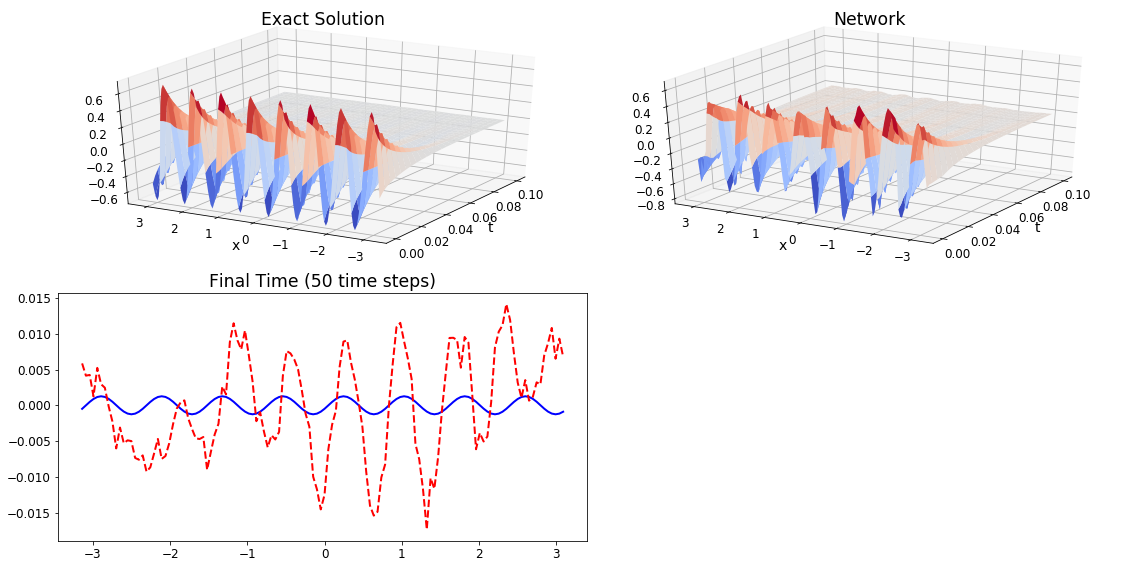

In [21]:
# Inputs
data = 'val'  # 'train', 'val', or 'test'
IC = 7  # index of initial condition

ind = IC*(params['len_time']-params['num_shifts'])+30

if data == 'train':
    outputs = train_outputs
    data_tensor = data_train_tensor
elif data == 'val':
    outputs = val_outputs
    data_tensor = data_val_tensor
else:
    outputs = test_outputs
    data_tensor = data_test_tensor


# Exact solution (from data set)
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,ind,:]

fig = plt.figure(figsize=(16,8)) 

ax = fig.add_subplot(2, 2, 1, projection='3d')
surf = ax.plot_surface(T, X, np.transpose(exact), cmap=plt.cm.coolwarm)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Exact Solution', fontsize='xx-large')

ax = fig.add_subplot(2, 2, 2, projection='3d')
surf = ax.plot_surface(T, X, np.transpose(outputs[:,ind,:]), cmap=plt.cm.coolwarm)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Network', fontsize='xx-large')

ax = fig.add_subplot(2,2,3)
ax.plot(x_pts, exact[-1,:], "b-", linewidth=2)
ax.plot(x_pts, outputs[-1,ind,:], "r--", linewidth=2)
ax.set_title('Final Time (50 time steps)', fontsize='xx-large')
plt.tight_layout()
plt.show()   
#filename = './MeetingUpdates/PaperFigs/Burgers_exp21nn_IC' + str(IC)
#filename = './MeetingUpdates/PaperFigs/Burgers_exp21nn_test'
#plt.savefig(filename)

In [64]:
print(np.shape(data_val_tensor))

(51, 30000, 128)


In [8]:
num_val_traj = data_val_tensor.shape[1]/(params['len_time']-params['num_shifts'])
print(num_val_traj)
val_batch_size = int(num_val_traj/10)
print(val_batch_size)
batch_data_val = data_val_tensor[:, 1*val_batch_size:(1+1)*val_batch_size, :]
print(batch_data_val.shape)

30000.0
3000
(51, 3000, 128)


In [ ]:
# Run a session to get encoded (initial condition), prediction (final time), loss
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    
    val_loss = sess.run("loss:0", feed_dict={"x:0": data_val_tensor}) 

    print(val_loss)

INFO:tensorflow:Restoring parameters from ./Burgers_exp21pp/Burgers_Eqn_exp21_2019_05_13_08_18_37_356881_model.ckpt


3000: 0.09837085
15000: 0.01046206
All: 0.00677489
    
Taken in batches [0.09837085, 0.0981811, 0.09909293, 0.00618999, 0.00412265, 0.00418757, 0.00381059, 0.0052771, 0.0052386, 0.0052891]

In [10]:
max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
beg = 2*max_shifts_to_stack+3
end = beg + params['num_shifts']
tensor_list = ["decoder_outer/outputs/BiasAdd:0"]
for k in np.arange(beg,end):
    tensor_list.append("decoder_outer_"+str(k)+"/outputs/BiasAdd:0") 
print(tensor_list)

[u'decoder_outer/outputs/BiasAdd:0', u'decoder_outer_9/outputs/BiasAdd:0', u'decoder_outer_10/outputs/BiasAdd:0', u'decoder_outer_11/outputs/BiasAdd:0']


In [9]:
print(np.shape(data_tensor))
print(6000*48)

(4, 288000, 128)
288000


In [6]:
print(params) 

{'restore': 1, 'diag_L': 1, 'outer_autoencoder_loss_lam': 1.0, 'stop_condition': 'past max time', 'L1_lam': 0.0, 'been20min': array([0.03762283], dtype=float32), 'decay_rate': 0, 'Linf_lam': 0.0, 'num_encoder_weights': -1, 'first_guess': 0, 'add_identity': 0, 'rand_seed': 3316173162, 'relative_loss': 1, 'been3hr': array([0.03573356], dtype=float32), 'L2_lam': 1e-08, 'd': 0, 'model_restore_path': './Burgers_exp21nn/Burgers_Eqn_exp21_2019_05_20_12_57_43_376521_model.ckpt', 'rel_noise_flag': 0, 'min_4hr': 1, 'autoencoder_only': 0, 'scale_L': 0.1, 'min_2hr': 1, 'minTest': 0.028146546334028244, 'dist_L': 'tn', 'autoencoder_loss_lam': 1.0, 'scale': 0.1, 'conv1_filters': 32, 'opt_alg': 'adam', 'num_decoder_weights': -1, 'minRegTest': 0.02815067768096924, 'conv2_filters': 16, 'batch_flag': 0, 'minTrain': 0.0026331834960728884, 'delta_t': 0.002, 'denoising': 0, 'linear_encoder_layers': [-2], 'data_train_len': 20, 'batch_size': 64, 'linearity_loss_lam': 1.0, 'shifts_middle': array([ 1,  2,  3,  

In [28]:
# Save outputs of a particular network as .npy files
np.save(params['model_path'].replace('model.ckpt','train_outputs'), train_outputs, allow_pickle=False)
np.save(params['model_path'].replace('model.ckpt','val_outputs'), val_outputs, allow_pickle=False)


In [ ]:
# Load outputs from npy file and create figures
train_outputs = np.load(params['model_path'].replace('model.ckpt','train_outputs'))
val_outputs = np.load(params['model_path'].replace('model.ckpt','val_outputs'))

In [ ]:
# Inputs
data = 'val'  # 'train', 'val', or 'test'
IC = 7  # index of initial condition

ind = IC*(params['len_time']-params['num_shifts'])+30

if data == 'train':
    outputs = train_outputs
    data_tensor = data_train_tensor
elif data == 'val':
    outputs = val_outputs
    data_tensor = data_val_tensor
else:
    outputs = test_outputs
    data_tensor = data_test_tensor


# Exact solution (from data set)
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,ind,:]

fig = plt.figure(figsize=(16,8)) 

ax = fig.add_subplot(2, 2, 1, projection='3d')
surf = ax.plot_surface(T, X, np.transpose(exact), cmap=plt.cm.coolwarm)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Exact Solution', fontsize='xx-large')

ax = fig.add_subplot(2, 2, 2, projection='3d')
surf = ax.plot_surface(T, X, np.transpose(outputs[:,ind,:]), cmap=plt.cm.coolwarm)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Network', fontsize='xx-large')

ax = fig.add_subplot(2,2,3)
ax.plot(x_pts, exact[-1,:], "b-", linewidth=2)
ax.plot(x_pts, outputs[-1,ind,:], "r--", linewidth=2)
ax.set_title('Final Time (50 time steps)', fontsize='xx-large')
plt.tight_layout()
plt.show()   
#filename = './MeetingUpdates/PaperFigs/Burgers_exp21nn_IC' + str(IC)
#filename = './MeetingUpdates/PaperFigs/Burgers_exp21nn_test'
#plt.savefig(filename)